In [1]:
# Chargement des librairies nécessaires
library(ggplot2)
library(tidyverse)
library(gridExtra)
library(GGally)
library(plotly)
library(corrplot)
library(reshape2)
library(FactoMineR) 
library(factoextra)
library(glmnet) 
library(ggfortify)
library(pROC)
library(ROCR)
library(repr)
library(caret)
library(rpart)
library(MLmetrics)

# fix random seed for reproducibility
set.seed(1234)

## GRAPH SETTINGS ##
# Save original parameters (optional)
original_par <- par(no.readonly = TRUE)

# Set global scaling factors (1.5x default size)
par(
  cex.lab = 1.5,   # Axis labels
  cex.axis = 1.5,  # Axis text (tick labels)
  cex.main = 1.5,  # Main title
  cex.sub = 1.5    # Subtitle
)

# Define a custom theme with larger fonts
custom_theme <- theme(
  text = element_text(size = 16),            # Global text size
  axis.title = element_text(size = 18),      # Axis labels
  axis.text = element_text(size = 14),       # Axis tick labels
  plot.title = element_text(size = 20),      # Main title
  plot.subtitle = element_text(size = 16)    # Subtitle
)

# Apply the theme to all future plots
theme_set(custom_theme)


## DATA LOADING & PROCESSING ##
# Load data
path <- "../../" # modifier le nombre de ../ si nécessaire
gym <- read.table(paste(path, "gym_members_exercise_tracking.csv", sep = ""),
                    sep = ",", header = TRUE)

gym[,'Gender'] <- as.factor(gym[,'Gender'])
gym[,'Workout_Type'] <- as.factor(gym[,'Workout_Type'])
gym[,'Experience_Level'] <- as.factor(gym[,'Experience_Level'])
gym[,'Workout_Frequency..days.week.'] <- as.factor(gym[,'Workout_Frequency..days.week.'])

gym[, "Weight..kg."] <- log(gym[,"Weight..kg."])

max_fat <- max(gym[,"Fat_Percentage"])
gym[, "Fat_Percentage"] <- sqrt((max_fat + 1) - gym[,"Fat_Percentage"])

# renome les variables Weight..kg. et BMI en LWeight et LBMI
names(gym)[names(gym) == "Weight..kg."] <- "LWeight"
names(gym)[names(gym) == "Fat_Percentage"] <- "SFat_Percentage"

gym <- gym %>% select(-c(BMI))

# divide data into training and testing sets for experience level
trainIndex <- createDataPartition(gym$Experience_Level, p = .8, 
                                  list = FALSE, 
                                  times = 1)
gym_train <- gym[ trainIndex,]
gym_test  <- gym[-trainIndex,]

# Normalize the data
gym_train_scaled = gym_train
scaler <- scale(gym_train[,-c(2,10,13,14)])

# Extract the center and scale attributes
center <- attr(scaler, "scaled:center")
scale <- attr(scaler, "scaled:scale")

gym_train_scaled[,-c(2,10,13,14)] <- scale(gym_train[,-c(2,10,13,14)], center = center, scale = scale)

gym_test_scaled = gym_test
gym_test_scaled[,-c(2,10,13,14)] <- scale(gym_test[,-c(2,10,13,14)], center = center, scale = scale)


cat("Data loaded and preprocessed")


## FUNCTION DEFINITIONS ##

# Function to plot residuals
# x: predicted values
# y: residuals
gplot.res <- function(x, y, titre = "titre"){
    ggplot(data.frame(x=x, y=y),aes(x,y))+
    geom_point(col = "blue")+#xlim(0, 250)+ylim(-155, 155)+
    ylab("Résidus")+ xlab("Valeurs prédites")+
    ggtitle(titre)+
    geom_hline(yintercept = 0,col="green")
}

# Function to plot ROC curve
# model: model to evaluate
# data: data to evaluate
# title: title of the plot
plot_roc <- function(model, data, title = "ROC curve"){
    pred <- predict(model, data, type = "response")
    roc <- roc(data$Experience_Level, pred)
    auc <- round(auc(roc), 2)
    plot(roc, main = title)
    text(0.8, 0.2, paste("AUC = ", auc), cex = 1.5)
}

# Function that compute R2

# compute_R2 <- function(model, newdata = NA){
#   if newdata == NA{
#     residuals <- predict(model)
#       rss <- sum()
#       tss <- 
# }
#   res.tree.cal.cp_high.test <- predict(tree.reg.cal.cp_high, newdata = gym_test)
#   mse_test_cal_cp_high <- mean((res.tree.cal.cp_high.test - gym_train[,"Calories_Burned"])^2)
#   rss_cal_cp_high <- sum((res.tree.cal.cp_high.test - gym_test[,"Calories_Burned"])^2)
#   tss_cal_cp_high <- sum((gym_test[,"Calories_Burned"] - mean(gym_test[,"Calories_Burned"]))^2)
#   r2_test_cal_cp_high <- 1 - rss_cal_cp_high / tss_cal_cp_high
# }

#Fonction qui calcule et affiche le pourcentage d'erreur 
#à partirde la matrice de confusion

pourcentage_erreur <- function(conf_matrix) {
  total_samples <- sum(conf_matrix)
  errors <- total_samples - sum(diag(conf_matrix))
  error_percentage <- (errors / total_samples) * 100
  print(paste("Pourcentage d'erreur :", round(error_percentage, 2), "%"))
}

# Initialiser tableau des résultats
results <- data.frame(
  Methode = character(),
  Accuracy = numeric(),
  LogLoss = numeric(),
  Temps = numeric(),
  stringsAsFactors = FALSE
)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: 'gridExtra'


The following object is masked from 'package:dplyr':

    combine


Warning message:
"package 'GGally' was built under R version 4.4.2"
Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Warning message:
"package 'plotly' was built under R version 4.4.2"

Attaching package: 'plotly'


The following object is masked from 'package:ggplot2':

    last_plot


The following object is masked from 'package:stats':

    filter


The follow

Data loaded and preprocessed

In [2]:
summary(gym_train_scaled)
summary(gym_test_scaled)

      Age              Gender       LWeight           Height..m.      
 Min.   :-1.70033   Female:384   Min.   :-2.06411   Min.   :-1.74278  
 1st Qu.:-0.88351   Male  :395   1st Qu.:-0.70877   1st Qu.:-0.79206  
 Median : 0.09668                Median :-0.05133   Median :-0.07902  
 Mean   : 0.00000                Mean   : 0.00000   Mean   : 0.00000  
 3rd Qu.: 0.91350                3rd Qu.: 0.67508   3rd Qu.: 0.55479  
 Max.   : 1.64864                Max.   : 2.18326   Max.   : 2.21854  
    Max_BPM            Avg_BPM          Resting_BPM      
 Min.   :-1.70393   Min.   :-1.66558   Min.   :-1.66962  
 1st Qu.:-0.84195   1st Qu.:-0.90414   1st Qu.:-0.84618  
 Median : 0.02003   Median :-0.07349   Median :-0.02273  
 Mean   : 0.00000   Mean   : 0.00000   Mean   : 0.00000  
 3rd Qu.: 0.88201   3rd Qu.: 0.89561   3rd Qu.: 0.80072  
 Max.   : 1.65779   Max.   : 1.72627   Max.   : 1.62417  
 Session_Duration..hours. Calories_Burned     Workout_Type SFat_Percentage   
 Min.   :-2.20445  

      Age              Gender       LWeight           Height..m.      
 Min.   :-1.70033   Female: 78   Min.   :-2.06411   Min.   :-1.74278  
 1st Qu.:-0.88351   Male  :116   1st Qu.:-0.74142   1st Qu.:-0.71283  
 Median :-0.06669                Median :-0.01540   Median :-0.07902  
 Mean   :-0.05448                Mean   : 0.03039   Mean   : 0.10352  
 3rd Qu.: 0.66845                3rd Qu.: 0.77183   3rd Qu.: 0.95092  
 Max.   : 1.64864                Max.   : 2.14138   Max.   : 2.21854  
    Max_BPM            Avg_BPM         Resting_BPM      
 Min.   :-1.70393   Min.   :-1.6656   Min.   :-1.66962  
 1st Qu.:-0.66956   1st Qu.:-0.9041   1st Qu.:-0.84618  
 Median : 0.10623   Median :-0.1427   Median : 0.11451  
 Mean   : 0.05024   Mean   :-0.1024   Mean   : 0.03953  
 3rd Qu.: 0.88201   3rd Qu.: 0.7399   3rd Qu.: 0.93796  
 Max.   : 1.65779   Max.   : 1.6571   Max.   : 1.62417  
 Session_Duration..hours. Calories_Burned      Workout_Type SFat_Percentage   
 Min.   :-2.17545        

## Regression logistique 

La régréssion logistque réalisée ici est multinomiale pour être adaptée à notre problème de clasification et prend en comte les interactions doubles. 
La fonction R glmnet calcule tous les modèles lasso (pénalisation L1, alpha=1 en argument) pour une séquence de 100 lambda puis évalue leurs performances par validation croisée. 

 Les données utilisés sont les donnnés "scalers" (moyenne à 0 ecart-type à 1) pour ne pas donner plus d'importance à certaines variables (glmnet fait des pénalisation avec les normes L1 (alpha=1)).

[1] "Temps d'exécution :  3.73895788192749"
[1] "Best Lambda : 0.000566060562817942"
[1] "LSE Lambda : 0.0069786591919684"


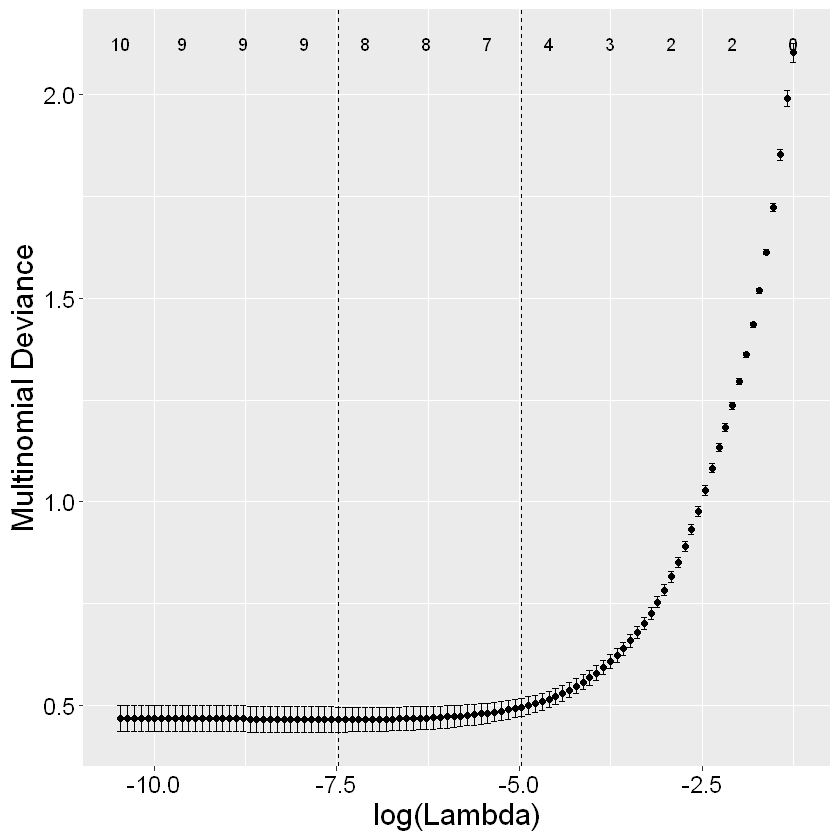

In [3]:
t0 <- Sys.time()

# Convertir les données en matrice pour glmnet
# si ~ .^2 => erreur = 15% environ
x <- model.matrix(Experience_Level ~ ., data = gym_train_scaled)[, -1] # Prédicteurs 
y <- model.matrix(~ Experience_Level + 0, data = gym_train_scaled)      # Réponse

# Ajustement du modèle avec validation croisée
cv_fit <- cv.glmnet(x, y, family = "multinomial", alpha = 1)
autoplot(cv_fit)

# Afficher le temps d'exécution
t <- Sys.time()
execution_time <- t - t0
print(paste("Temps d'exécution : ", execution_time))

# Afficher le meilleur lambda
best_lambda <- cv_fit$lambda.min
print(paste("Best Lambda :", best_lambda))

#Affiche le plus grand lambda envisageable
lse_lambda <- cv_fit$lambda.1se
print(paste("LSE Lambda :", lse_lambda))

- lambda petit: moins de pénalisation, modèle complexe avec beaucoup de variables non nulles 
- lambda grand: plus depénalisation, modèle simple avec bcp de coefs nulles
- courbe : performance sur validation croisée sauf forme erreur de prédiction

Le plus grand lambda qui minimise la deviance est lambda min = 0.000295; et le plus grand lambda dont la déviance est à moins de un écart-type du minimum est LSE lambda= 0.0052791. On garde ce dernier qui fait un compromis entre la simplicité et la robustesse du modèle. 

Le choix du lamabda nous permet de réduire le nombre de coeffcients selectionnés.

In [4]:
# Choix du lambda
chosen_lambda <- lse_lambda

# Ajuster le modèle final avec le meilleur lambda
final_model <- glmnet(x, y, family = "multinomial", alpha = 1, lambda = chosen_lambda)

# Afficher les coefficients du modèle final
print(coef(final_model))

$Experience_Level1
18 x 1 sparse Matrix of class "dgCMatrix"
                                        s0
                                2.76270639
Age                             0.04454661
GenderMale                      .         
LWeight                         .         
Height..m.                      0.01526018
Max_BPM                         .         
Avg_BPM                         .         
Resting_BPM                     .         
Session_Duration..hours.       -1.15464048
Calories_Burned                -0.17927720
Workout_TypeHIIT                .         
Workout_TypeStrength            .         
Workout_TypeYoga                .         
SFat_Percentage                 .         
Water_Intake..liters.           .         
Workout_Frequency..days.week.3  .         
Workout_Frequency..days.week.4 -5.94077471
Workout_Frequency..days.week.5  .         

$Experience_Level2
18 x 1 sparse Matrix of class "dgCMatrix"
                                        s0
                 

In [5]:
# Extraire tous les coefficients
coefs_list <- coef(final_model)

# Pour chaque classe, compter les coefficients non nuls (hors intercept)
nombre_non_nuls_par_classe <- sapply(coefs_list, function(m) {
  sum(m[-1, ] != 0)  # Enlève intercept (-1) et compte les non-zéros
})

# Afficher
print(nombre_non_nuls_par_classe)

Experience_Level1 Experience_Level2 Experience_Level3 
                5                 7                 4 


La methode Lasso avec le lambda 1se permet de garder uniquement 5 coefficients pour la classe Experience_Level1, 7 pour Experience_Level2 et 4 pour Experience_Level3, contre 17 par classe à l'origine.  

In [6]:

# Convertir les données test en matrice pour glmnet de la meme manière 
#que pour les données d'apprentissage 
x_test <- model.matrix(Experience_Level ~ ., data = gym_test_scaled)[, -1]  # Prédicteurs
y_test <- model.matrix(~ Experience_Level + 0, data = gym_test_scaled)  # Réponse réelle (one-hot)

# Prédiction des probabilités pour chaque classe
pred_probs <- predict(final_model, newx = x_test, type = "response") 

# Modification nécessaires pour tracer les courbes ROC 
probabilities_logit <- pred_probs[,,1]
probabilities_logit <- as.data.frame(probabilities_logit)
colnames(probabilities_logit) <- c("1", "2", "3")


# Convertir les probabilités en classes prédictes (classe avec proba max)
pred_class <- apply(pred_probs, 1, which.max)
pred_class <- factor(pred_class, levels = 1:3)
# Convertir y_test en indices de classes réelles
true_class_test <- apply(y_test, 1, which.max)

# Construire la matrice de confusion
conf_matrix_logit <- table(Predicted = pred_class, Actual = true_class_test)
conf_matrix_test <- confusionMatrix(pred_class, gym_test$Experience_Level)
print(conf_matrix_logit)
# Calcul du log loss
log_loss <- MultiLogLoss(y_true = y_test, y_pred = pred_probs[,,1])
#log_loss <- -mean(log(probabilities_logit[cbind(seq_len(nrow(probabilities_logit)), true_class_test)]))
print(paste("Log Loss:", round(log_loss, 4)))
pourcentage_erreur(conf_matrix_logit)

         Actual
Predicted  1  2  3
        1 67 19  0
        2  8 62  0
        3  0  0 38
[1] "Log Loss: 0.2558"
[1] "Pourcentage d'erreur : 13.92 %"


On voit qu'il y a eu des erreures de prédiction pour 28 persones, et ces erreures sont toujours entre les niveau d'expérience 1 et deux. Le pourcentage d'erreure de prédiction est de 14.43%, assez élevé. 

In [7]:
# Calcul de l'AUC multiclass 
roc_result <- multiclass.roc(true_class_test, probabilities_logit)
auc_value <- auc(roc_result)

results <- rbind(results, data.frame(
  Methode = "Logit",
  Accuracy = round(conf_matrix_test$overall["Accuracy"], 4),
  LogLoss = log_loss,
  Temps = as.numeric(execution_time, units = "secs")
))

## Analyse Discriminante Linéaire (LDA)

In [8]:
# Initialisation de la validation croisée avec 10 folds
# Intervient dès que l'on utilise la
# fonction train du package caret
param_train<-trainControl(method="cv",number=10)

In [9]:
t0 <- Sys.time()

lda.fit<-train(Experience_Level ~ ., data = gym_train_scaled, method="lda")

# erreur par validation croisée  en analyse discriminante linéaire
lda.fit <- train(Experience_Level ~ ., data = gym_train_scaled, method="lda",trControl=param_train)

predictions_lda <- predict(lda.fit, gym_test_scaled)
probabilities_lda <- predict(lda.fit, gym_test_scaled, type="prob")

# Afficher le temps d'exécution
t <- Sys.time()
execution_time <- t - t0
print(paste("Temps d'exécution : ", execution_time))

# estimer le taux d'erreur à partir de la matrice de confusion
conf_matrix_lda=table(gym_test_scaled[,"Experience_Level"],predictions_lda)
conf_matrix_test_lda <- confusionMatrix(predictions_lda, gym_test_scaled$Experience_Level)
print(conf_matrix_lda)
# Calcul du log loss
log_loss <- -mean(log(probabilities_lda[cbind(seq_len(nrow(probabilities_lda)), true_class_test)]))
#log_loss <- MultiLogLoss(y_true = y_test, y_pred = pred_probs[,,1])
print(paste("Log Loss:", round(log_loss, 4)))
pourcentage_erreur(conf_matrix_lda)



[1] "Temps d'exécution :  2.24697709083557"
   predictions_lda
     1  2  3
  1 64 11  0
  2 17 64  0
  3  0  0 38
[1] "Log Loss: 0.2299"
[1] "Pourcentage d'erreur : 14.43 %"


Le pourcentage d'erreur est très proche de celui obtenus avec la regression logistque optimisée par Lasso. Les erreurs sont à nouveau entre les niveaux d'expérience 1 et 2, cette fois il y a plus d'individus prédits du niveau 2 alors qu'il sont du niveau 1.

In [10]:
# AUC multiclasse
roc_result <- multiclass.roc(true_class_test, probabilities_lda)
auc_value <- auc(roc_result)

# Ajouter au tableau des résultats
results <- rbind(results, data.frame(
  Methode = "LDA",
  Accuracy = round(conf_matrix_test_lda$overall["Accuracy"], 4),
  LogLoss = log_loss,
  Temps = as.numeric(execution_time, units = "secs")
))

## K plus proches voisins (KNN)

In [11]:
#knn.fit<-train(Experience_Level ~ ., data = gym_train_scaled ,method="knn")

t0 <- Sys.time() 

# erreur par validation croisée  en kNN
knn.fit <- train(Experience_Level ~ ., data = gym_train_scaled, method="knn",trControl=param_train,tuneLength=20)

predictions_knn <-predict(knn.fit, gym_test_scaled)
probabilities_knn <-predict(knn.fit, gym_test_scaled, type="prob")

# Afficher le temps d'exécution
t <- Sys.time()
execution_time <- t - t0
print(paste("Temps d'exécution : ", execution_time))

# estimer le taux d'erreur à partir de la matrice de confusion
conf_matrix_knn=table(gym_test_scaled[,"Experience_Level"],predictions_knn)
conf_matrix_test_knn <- confusionMatrix(predictions_knn, gym_test_scaled$Experience_Level)
print(conf_matrix_knn)
# Calcul du log loss

log_loss <- -mean(log(probabilities_knn[cbind(seq_len(nrow(probabilities_knn)), true_class_test)]))
print(paste("Log Loss:", round(log_loss, 4)))
pourcentage_erreur(conf_matrix_knn)

[1] "Temps d'exécution :  2.82002687454224"
   predictions_knn
     1  2  3
  1 43 32  0
  2 11 70  0
  3  0  0 38
[1] "Log Loss: 0.4993"
[1] "Pourcentage d'erreur : 22.16 %"


Le pourcentage d'erreur de prédiction est nettement plus élevé que pour les deux derniers modèle, il dépasse les 20%. Le modèle de prédiction par KNN est mauvais. On retrouve que les niveau d'expérience 1 et 2 sont souvent mélangés. 

In [12]:
# AUC multiclasse
roc_result <- multiclass.roc(true_class_test, probabilities_knn)
auc_value <- auc(roc_result)

# Ajouter au tableau des résultats
results <- rbind(results, data.frame(
  Methode = "KNN",
  Accuracy = round(conf_matrix_test_knn$overall["Accuracy"], 4),
  LogLoss = log_loss,
  Temps = as.numeric(execution_time, units = "secs")
))

## SVM 

### SVM kernel radial 

Warning message:
"package 'e1071' was built under R version 4.4.3"


[1] "Temps d'exécution :  30.3401279449463"


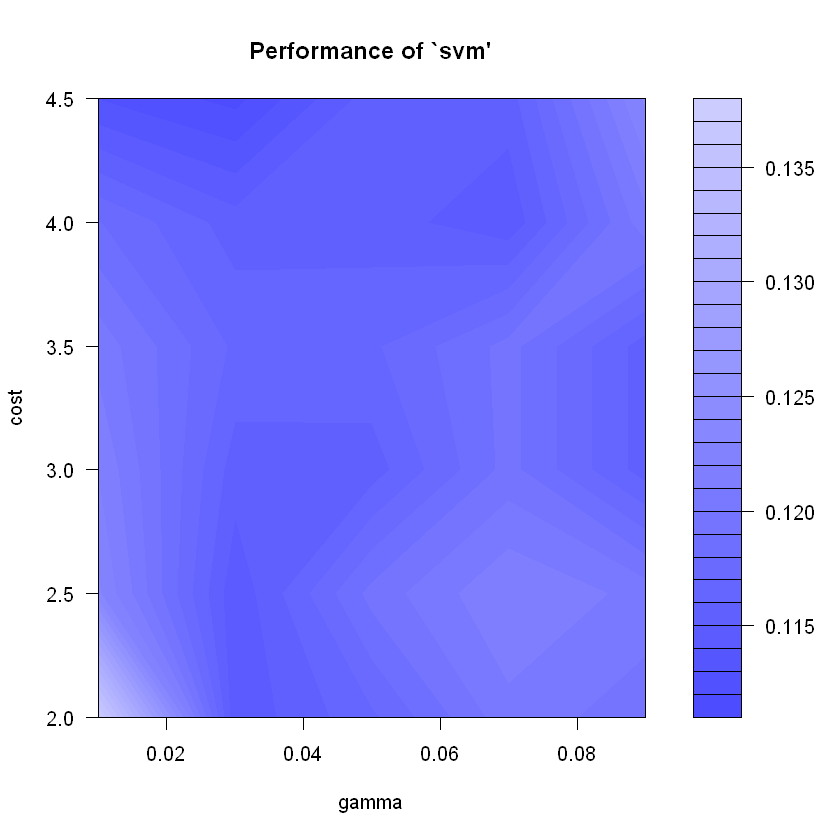

In [13]:
library(e1071)
t0 <- Sys.time()

#La zone de recherche est volontairement déjà centré sur les paramètres optimaux
svm.rad.tune = tune.svm(Experience_Level ~ ., data = gym_train_scaled, cost = c(2, 2.5, 3, 3.5,4,4.5), 
    gamma = seq(0.01, 0.1, by = 0.02), kernel= "radial")
plot(svm.rad.tune)

# Afficher le temps d'exécution
t <- Sys.time()
execution_time <- t - t0
print(paste("Temps d'exécution : ", execution_time))

In [14]:
svm.rad = svm(Experience_Level ~ ., data = gym_train_scaled, 
              cost = svm.rad.tune$best.parameters$cost, 
              gamma = svm.rad.tune$best.parameters$gamma,
              probability=TRUE)

pred.svm.rad=predict(svm.rad,newdata=gym_test_scaled,probability=TRUE)

#Utiles pour les courbes ROC :
probabilities_svm.rad <- attr(pred.svm.rad, "probabilities")
probabilities_svm.rad <- as.data.frame(probabilities_svm.rad)
probabilities_svm.rad <- probabilities_svm.rad[, c("1", "2", "3")]

conf_matrix_svm.rad=table(gym_test_scaled[,"Experience_Level"],pred.svm.rad)
conf_matrix_test_svm.rad <- confusionMatrix(pred.svm.rad, gym_test_scaled$Experience_Level)
print(conf_matrix_svm.rad)
# Calcul du log loss
log_loss <- -mean(log(probabilities_svm.rad[cbind(seq_len(nrow(probabilities_svm.rad)), true_class_test)]))
print(paste("Log Loss:", round(log_loss, 4)))
pourcentage_erreur(conf_matrix_svm.rad)

   pred.svm.rad
     1  2  3
  1 63 12  0
  2 17 64  0
  3  0  0 38
[1] "Log Loss: 0.2775"
[1] "Pourcentage d'erreur : 14.95 %"


Le modèle présente des performances similaires à celles de la régression logistique et de l’analyse discriminante linéaire, avec une erreur de prédiction de 14,95 %. Les erreurs concernent uniquement une confusion entre les niveaux 1 et 2. En revanche, le temps d’exécution est long, autour de 30 secondes.

In [15]:
# AUC multiclasse
roc_result <- multiclass.roc(true_class_test, probabilities_svm.rad)
auc_value <- auc(roc_result)

# Ajouter au tableau des résultats
results <- rbind(results, data.frame(
  Methode = "SVM radiale",
  Accuracy = round(conf_matrix_test_svm.rad$overall["Accuracy"], 4),
  LogLoss = log_loss,
  Temps = as.numeric(execution_time, units = "secs")
))

### SVM kernel polynomial

[1] "Temps d'exécution :  13.1265280246735"


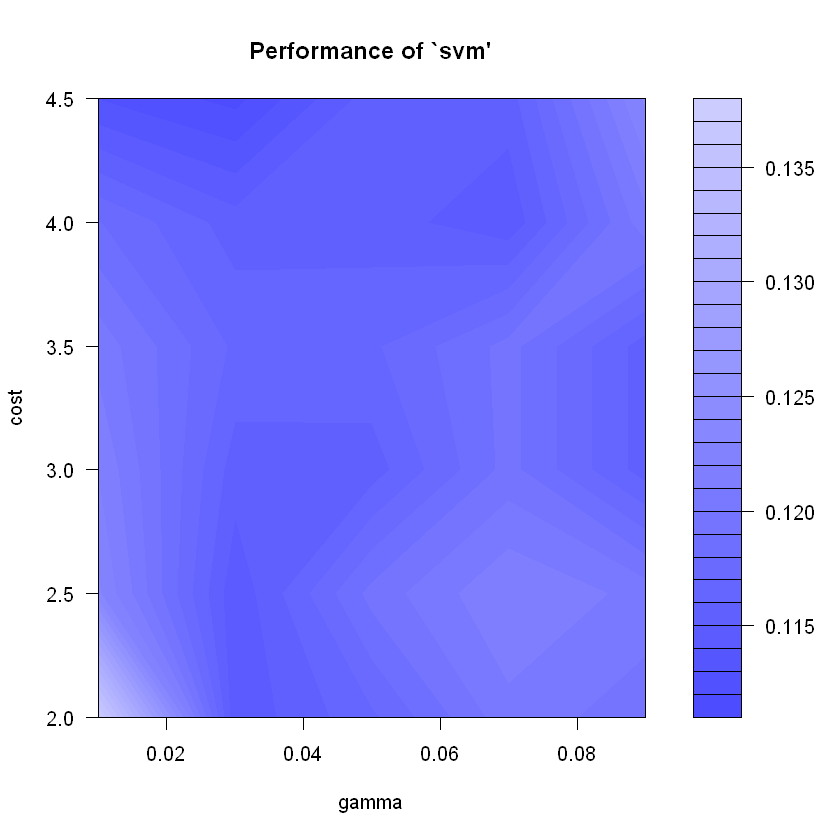

In [16]:
# On peut rajouter :
# coef0 = c(0.5,1,1.5), degree= c(2,3)
# Mais c'est trop long

t0 <- Sys.time()

svm.pol.tune = tune.svm(Experience_Level ~ ., data = gym_train_scaled, kernel= "polynomial", cost = c(3.5,4,4.5,5), 
    gamma = seq(0.01, 0.1, by = 0.02), coef0=1, degree=3) 

plot(svm.rad.tune)

# Afficher le temps d'exécution
t <- Sys.time()
execution_time <- t - t0
print(paste("Temps d'exécution : ", execution_time))

Le temps d'execution plus raisonnable (11s). En revenche il de plusieurs minutes quand on ajoute l'optimisation de 'cef0' et 'degree'.

In [17]:
svm.pol = svm(Experience_Level ~ ., data = gym_train_scaled, kernel= "polynomial",
              cost = svm.pol.tune$best.parameters$cost, 
              gamma = svm.pol.tune$best.parameters$gamma,
              coef0 = 1,
              degree = 3,
              probability=TRUE)

pred.svm.pol=predict(svm.pol,newdata=gym_test_scaled,probability=TRUE)

#Utiles pour les courbes ROC :
probabilities_svm.pol <- attr(pred.svm.pol, "probabilities")
probabilities_svm.pol <- as.data.frame(probabilities_svm.pol)
probabilities_svm.pol <- probabilities_svm.pol[, c("1", "2", "3")]

conf_matrix_svm.pol=table(gym_test_scaled[,"Experience_Level"],pred.svm.pol)
conf_matrix_test_svm.pol <- confusionMatrix(pred.svm.pol, gym_test_scaled$Experience_Level)
print(conf_matrix_svm.pol)
# Calcul du log loss
log_loss <- -mean(log(probabilities_svm.pol[cbind(seq_len(nrow(probabilities_svm.pol)), true_class_test)]))
print(paste("Log Loss:", round(log_loss, 4)))
pourcentage_erreur(conf_matrix_svm.pol)

   pred.svm.pol
     1  2  3
  1 64 11  0
  2 17 64  0
  3  0  0 38
[1] "Log Loss: 0.2544"
[1] "Pourcentage d'erreur : 14.43 %"


Pas d'amélioration par rapport au kernel radial sur l'erreur mais une diminution de 20s du temps d'execution. 

In [18]:
# AUC multiclasse
roc_result <- multiclass.roc(true_class_test, probabilities_svm.pol)
auc_value <- auc(roc_result)

# Ajouter au tableau des résultats
results <- rbind(results, data.frame(
  Methode = "SVM polynomiale",
  Accuracy = round(conf_matrix_test_svm.pol$overall["Accuracy"], 4),
  LogLoss = log_loss,
  Temps = as.numeric(execution_time, units = "secs")
))

## CART & Agregation
### Classification Trees

- Fit a classification tree.
- Prune the tree using cross-validation.
- Plot: Decision tree structure.

Warning message:
"package 'rpart.plot' was built under R version 4.4.3"


Test Set Performance:
- Accuracy: 0.8711 
- Log loss: 0.2528 (lower is better)
- Confusion Matrix:
          Reference
Prediction  1  2  3
         1 64 14  0
         2 11 67  0
         3  0  0 38

Training Set Performance:
- Accuracy: 0.9474 
- Log loss: 0.1257 (lower is better)
- Confusion Matrix:
          Reference
Prediction   1   2   3
         1 276  16   0
         2  25 309   0
         3   0   0 153
Nombre de noeuds dans l'arbre :  37 
Nombre de feuilles dans l'arbre :  19 


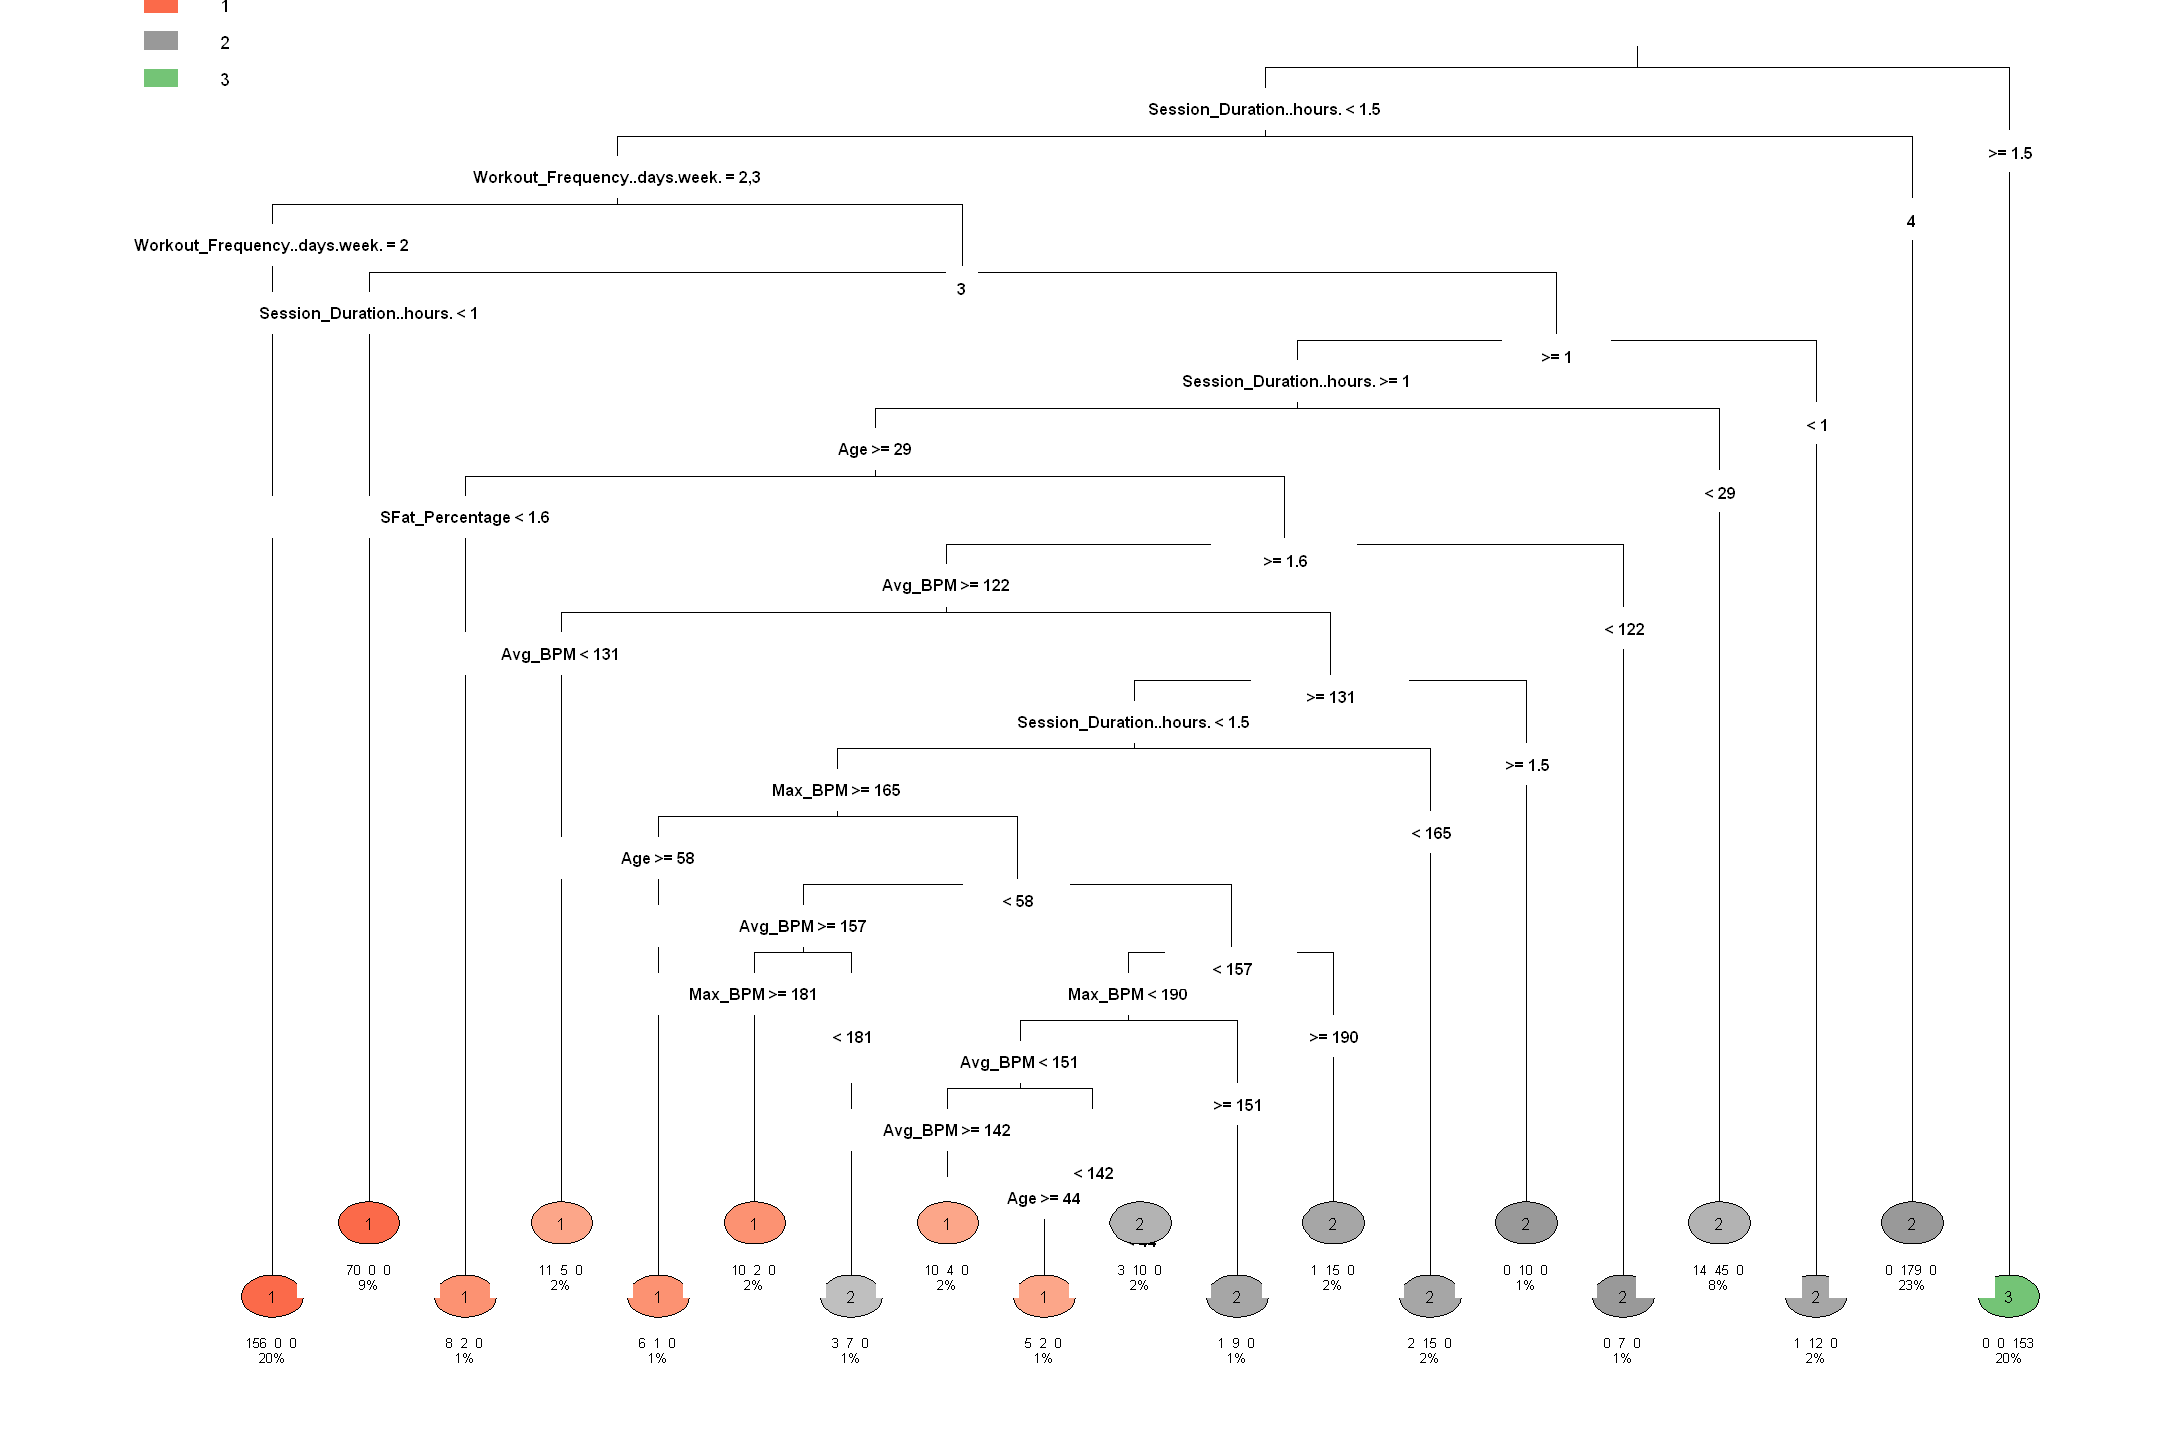

In [19]:
library(rpart)
library(rpart.plot)

# Fit a regression tree model for Experience_Level using the training set
tree.reg.exp <- rpart(Experience_Level ~ ., data = gym_train, control=rpart.control(cp=0.0001))

options(repr.plot.width=18, repr.plot.height=12)
# Plot the tree
rpart.plot(tree.reg.exp, extra = 101, type = 3, under = TRUE, cex = 0.8, tweak = 1)

# Convert the target to binary for ROC analysis
# Here we're treating Experience_Level as a binary classification problem
# First, get predicted probabilities for each class
pred_exp_tree_test <- predict(tree.reg.exp, gym_test, type = "prob")
pred_exp_tree_train <- predict(tree.reg.exp, gym_train, type = "prob")

# Get actual classes and convert to numeric matrix for MultiLogLoss
actual_classes <- gym_test$Experience_Level
actual_matrix <- model.matrix(~actual_classes-1)

# Calculate log loss using MultiLogLoss from MLmetrics
logloss_value <- MultiLogLoss(y_pred = pred_exp_tree_test, y_true = actual_matrix)

# Calculate confusion matrix for test set
pred_classes_test <- predict(tree.reg.exp, gym_test, type="class")
conf_matrix_test <- confusionMatrix(pred_classes_test, gym_test$Experience_Level)

cat("Test Set Performance:\n")
cat("- Accuracy:", round(conf_matrix_test$overall["Accuracy"], 4), "\n")
cat("- Log loss:", round(logloss_value, 4), "(lower is better)\n")
cat("- Confusion Matrix:\n")
print(conf_matrix_test$table)
cat("\n")

# Compute the metrics for the gym_train set
# Calculate confusion matrix for training set
pred_classes_train <- predict(tree.reg.exp, gym_train, type="class")
conf_matrix_train <- confusionMatrix(pred_classes_train, gym_train$Experience_Level)

# Get actual classes and convert to numeric matrix for MultiLogLoss
actual_classes_train <- gym_train$Experience_Level
actual_matrix_train <- model.matrix(~actual_classes_train-1)

# Calculate log loss using MultiLogLoss from MLmetrics
logloss_value_train <- MultiLogLoss(y_pred = pred_exp_tree_train, y_true = actual_matrix_train)


cat("Training Set Performance:\n")
cat("- Accuracy:", round(conf_matrix_train$overall["Accuracy"], 4), "\n")
cat("- Log loss:", round(logloss_value_train, 4), "(lower is better)\n")
cat("- Confusion Matrix:\n")
print(conf_matrix_train$table)

# Afficher le nombre de noeuds et de feuilles en français
cat("Nombre de noeuds dans l'arbre : ", length(tree.reg.exp$frame$var), "\n")
cat("Nombre de feuilles dans l'arbre : ", length(tree.reg.exp$frame$var[tree.reg.exp$frame$var == "<leaf>"]), "\n")

**Interprétation :**

L'arbre de régression construit avec un paramètre de complexité faible (`cp = 0.0001`) montre des performances solides mais indique un potentiel sur-apprentissage.

**Performance sur le jeu de test :**
- **Précision :** 87,11 % - Bonne capacité à classer correctement les observations.
- **Log loss :** 0.2528 - Indique des prédictions probabilistes bien calibrées.
- **Matrice de confusion :** Bonne distinction des classes, mais quelques confusions entre les classes 1 et 2.

**Performance sur le jeu d'entraînement :**
- **Précision :** 94,74 % - Ajustement presque parfait aux données d'entraînement.
- **Log loss :** 0.1257 - Confirme un ajustement très précis.

**Conclusion :**
L'écart entre les performances d'entraînement et de test (94,74 % vs 87,11 %) et les log loss (0.1257 vs 0.2528) suggère un sur-apprentissage dû à une complexité excessive. Malgré cela, le modèle capture bien les relations dans les données. Une optimisation du paramètre de complexité (`cp`) pourrait améliorer la généralisation.

### **Sélection du paramètre de complexité (cp) par validation croisée**

Pour éviter le sur-apprentissage et obtenir un arbre de régression optimal, il est important de choisir correctement le paramètre de complexité (`cp`). La méthode classique consiste à utiliser la validation croisée intégrée à l’algorithme `rpart` :

- On ajuste d’abord un arbre avec une valeur de `cp` très faible, ce qui permet à l’arbre de se développer au maximum.
- `rpart` réalise automatiquement une validation croisée (par défaut à 10 plis) et enregistre, pour différentes valeurs de `cp`, l’erreur de validation croisée associée.
- On visualise ensuite l’évolution de l’erreur de validation croisée en fonction de `cp` à l’aide de la fonction `plotcp()`.
- Le `cp` optimal est celui qui minimise l’erreur de validation croisée (`xerror`). On peut aussi appliquer la règle du 1-SE pour sélectionner un arbre plus simple si plusieurs valeurs de `cp` donnent des erreurs similaires.
- Enfin, on élague l’arbre initial avec la valeur optimale de `cp` pour obtenir un modèle plus parcimonieux et mieux généralisant.

Cette démarche permet de sélectionner automatiquement la complexité de l’arbre en fonction des performances sur des données non vues.

Le cp optimal est : 0.004405286 


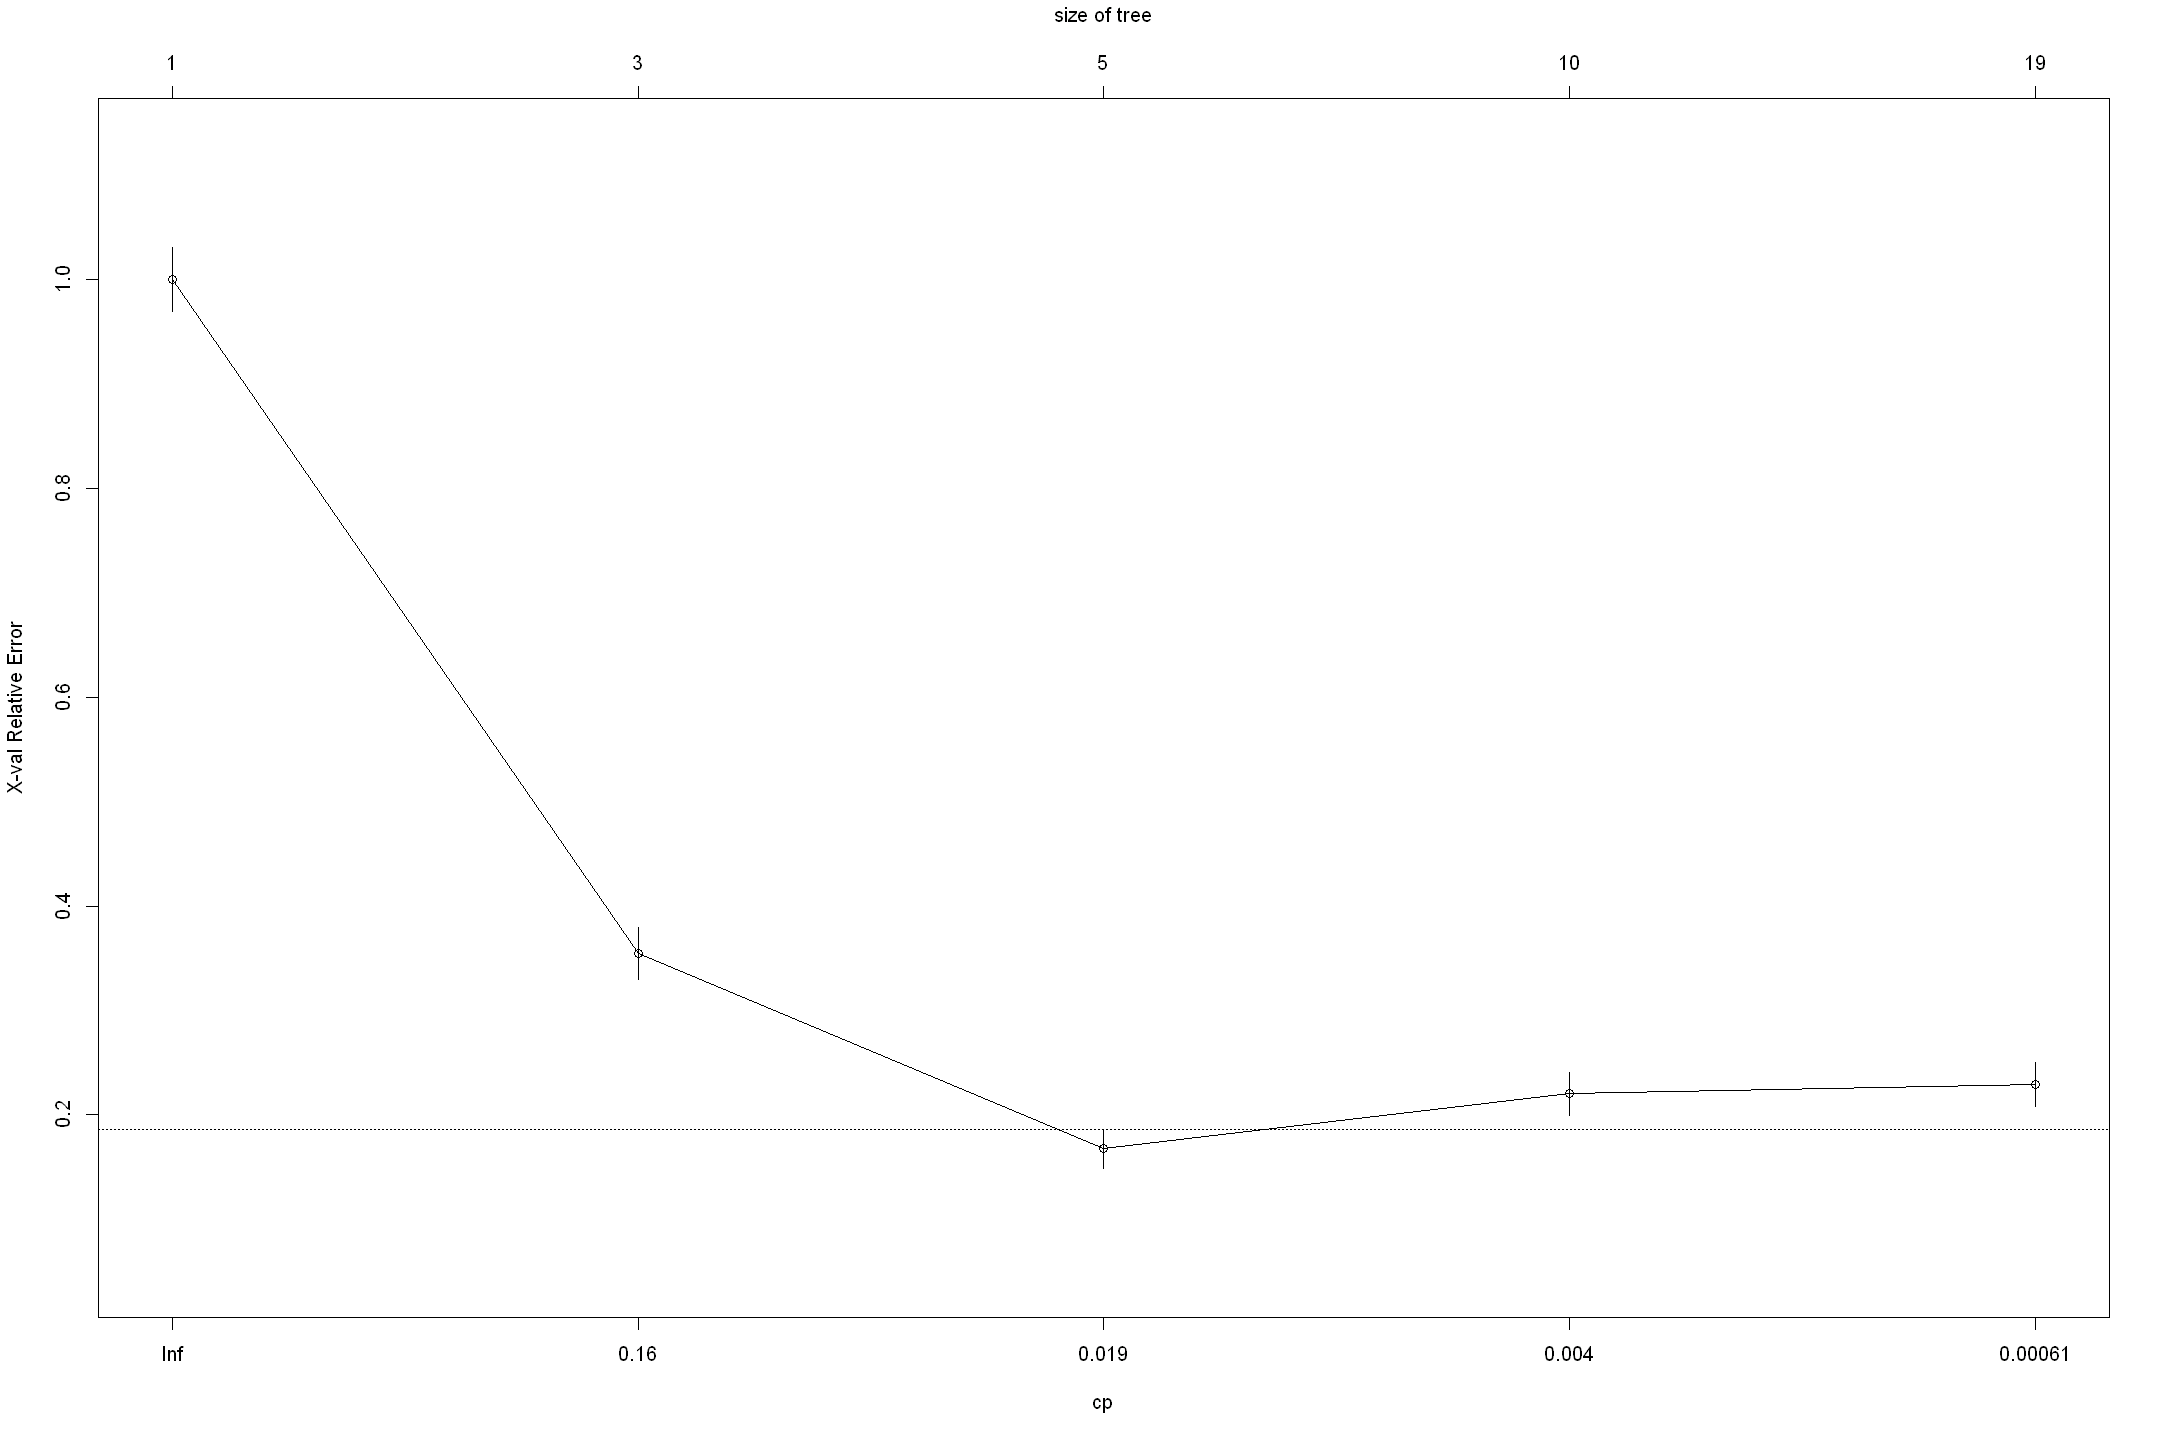

Nombre de noeuds dans l'arbre elague : 9 
Nombre de feuilles dans l'arbre elague : 19 


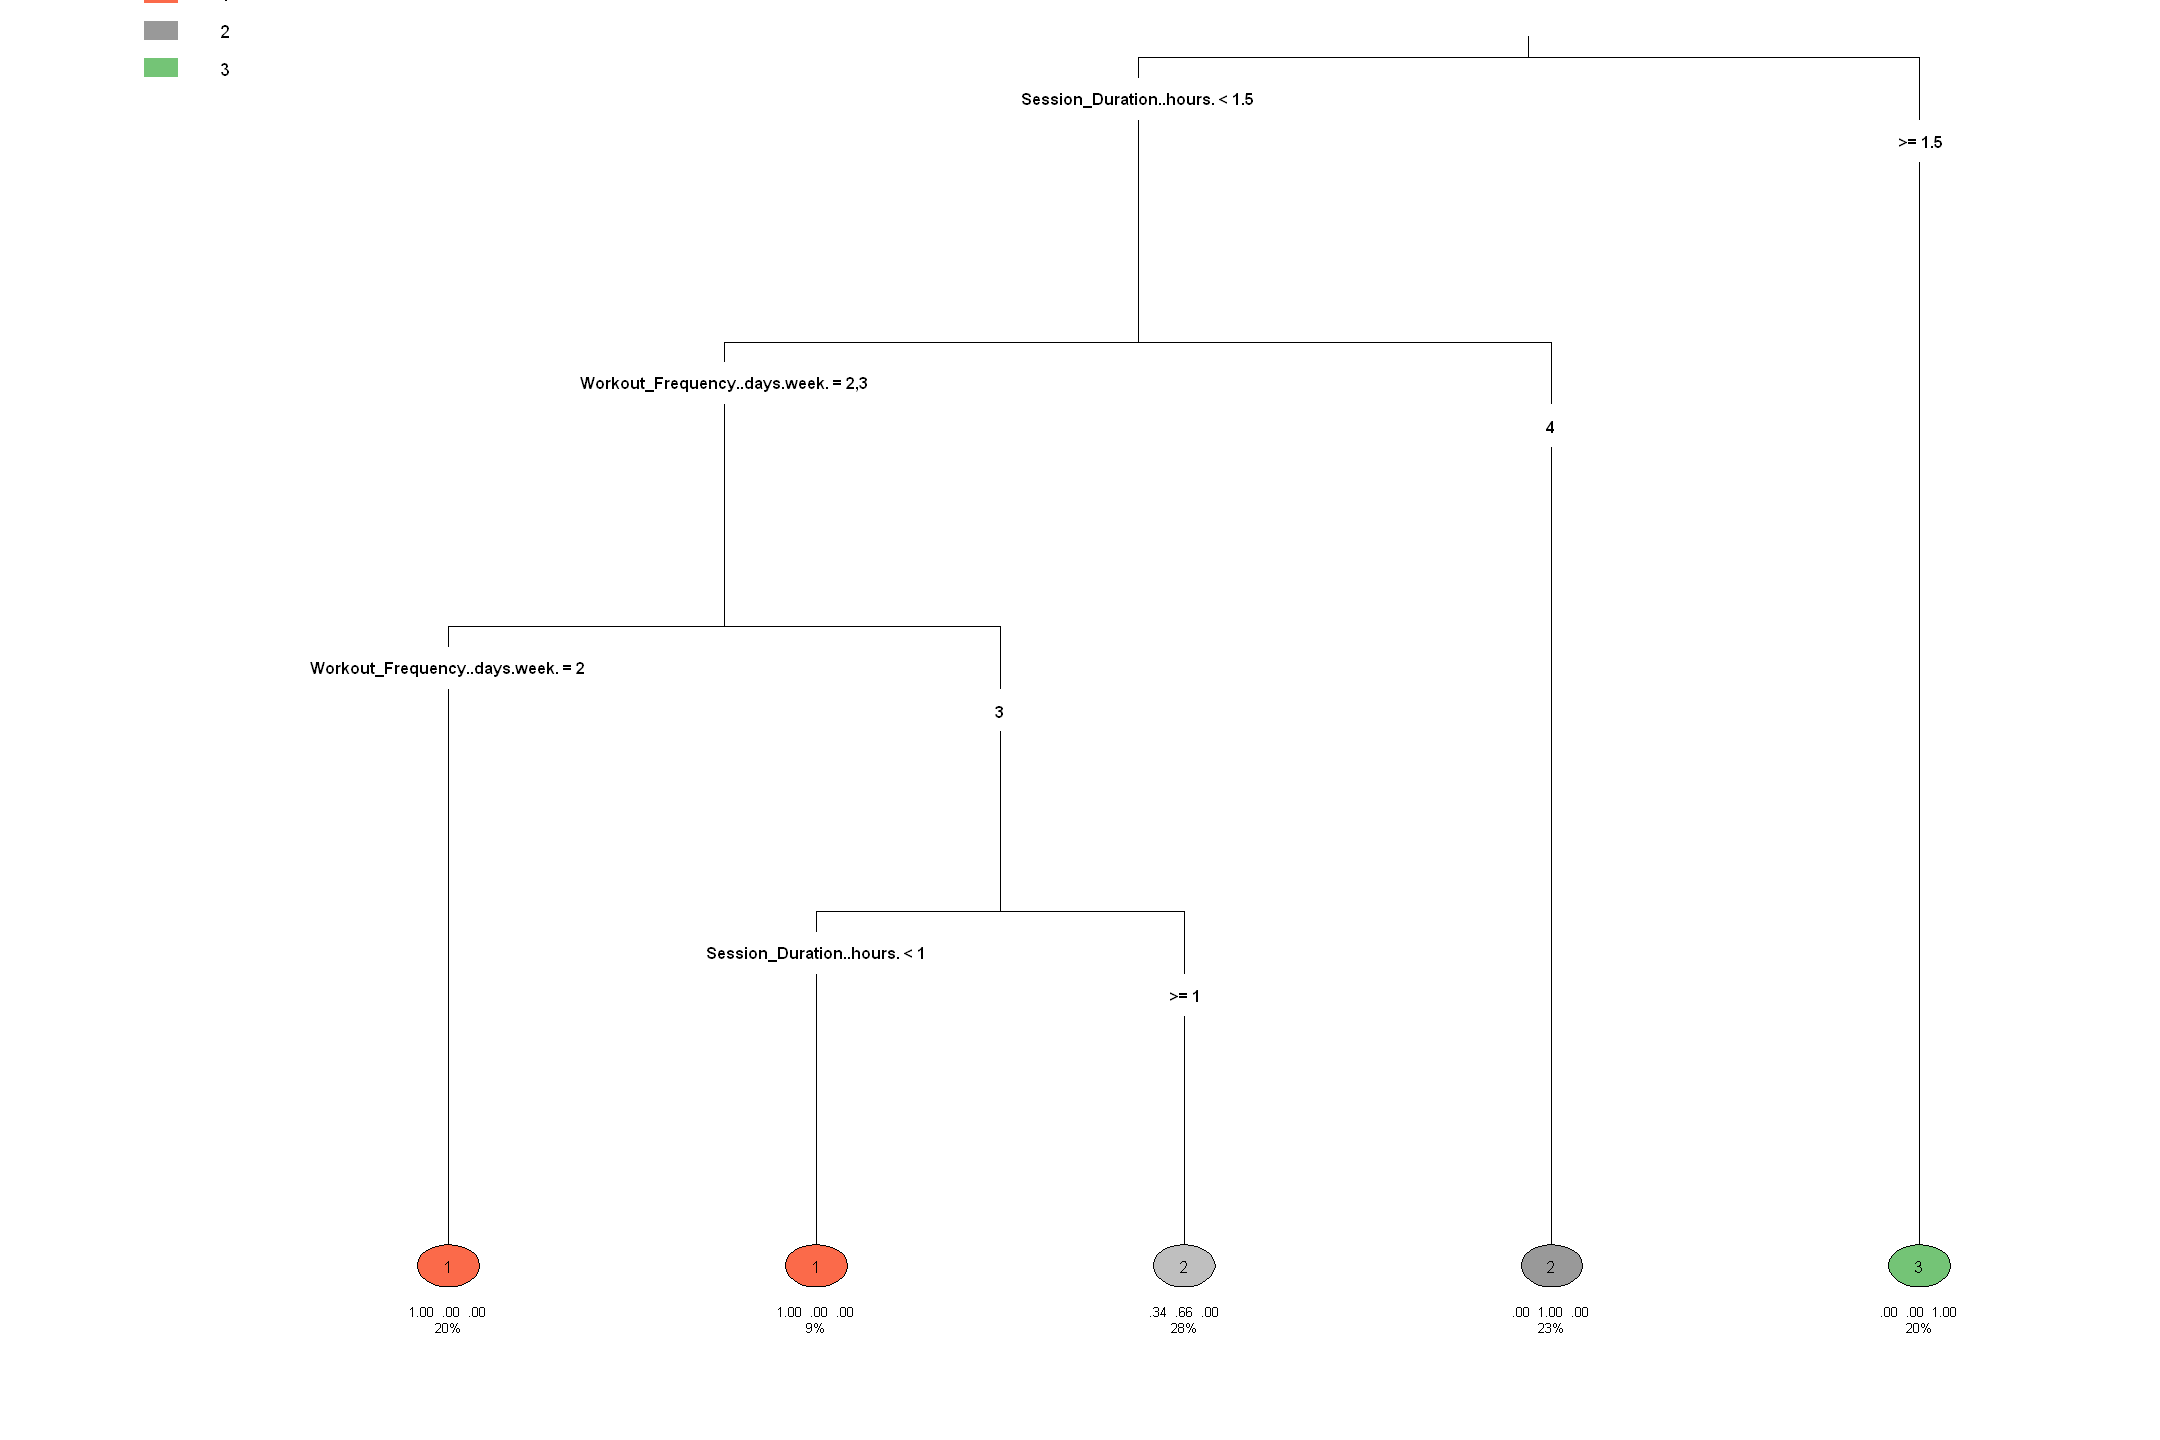

In [20]:
# Ajuster l'arbre avec un cp faible pour explorer toute la complexité
tree.class.exp <- rpart(Experience_Level ~ ., data = gym_train, method = "class", control = rpart.control(cp = 0.0001))

# Visualiser la courbe d'erreur de validation croisée
plotcp(tree.class.exp)

# Extraire la table des cp
cp_table <- tree.class.exp$cptable

# Trouver le cp optimal (celui qui minimise l'erreur de validation croisée)
min_xerror_idx <- which.min(cp_table[,"xerror"])
cp_optimal <- cp_table[min_xerror_idx, "CP"]
cat("Le cp optimal est :", cp_optimal, "\n")

# Élaguer l'arbre avec le cp optimal
tree.class.exp.pruned <- prune(tree.class.exp, cp = cp_optimal)

# Visualiser l'arbre élagué
rpart.plot(tree.class.exp.pruned, extra = 104, type = 3, under = TRUE, cex = 0.8, tweak = 1)

# Prédictions sur le jeu de test
pred_classes_test <- predict(tree.class.exp.pruned, gym_test, type = "class")

# Matrice de confusion
conf_matrix_test <- confusionMatrix(pred_classes_test, gym_test$Experience_Level)

# Afficher le nombre de noeuds et de feuilles
cat("Nombre de noeuds dans l'arbre elague :", length(tree.class.exp.pruned$frame$var), "\n")
cat("Nombre de feuilles dans l'arbre elague :", length(tree.class.exp$frame$var[tree.class.exp$frame$var == "<leaf>"]), "\n")

In [21]:
# Prédictions sur le jeu de test (classes et probabilités)
pred_classes_test <- predict(tree.class.exp.pruned, gym_test, type = "class")
pred_probs_test <- predict(tree.class.exp.pruned, gym_test, type = "prob")

# Prédictions sur le jeu d'entraînement (classes et probabilités)
pred_classes_train <- predict(tree.class.exp.pruned, gym_train, type = "class")
pred_probs_train <- predict(tree.class.exp.pruned, gym_train, type = "prob")

# Matrices de confusion
conf_matrix_test <- confusionMatrix(pred_classes_test, gym_test$Experience_Level)
conf_matrix_train <- confusionMatrix(pred_classes_train, gym_train$Experience_Level)

# Log loss (nécessite MLmetrics)
actual_matrix_test <- model.matrix(~gym_test$Experience_Level-1)
actual_matrix_train <- model.matrix(~gym_train$Experience_Level-1)
logloss_test <- MultiLogLoss(y_pred = pred_probs_test, y_true = actual_matrix_test)
logloss_train <- MultiLogLoss(y_pred = pred_probs_train, y_true = actual_matrix_train)

# Affichage des résultats
cat("Test Set Performance:\n")
cat("- Accuracy:", round(conf_matrix_test$overall["Accuracy"], 4), "\n")
cat("- Log loss:", round(logloss_test, 4), "(lower is better)\n")
cat("- Confusion Matrix:\n")
print(conf_matrix_test$table)
cat("\n")

cat("Training Set Performance:\n")
cat("- Accuracy:", round(conf_matrix_train$overall["Accuracy"], 4), "\n")
cat("- Log loss:", round(logloss_train, 4), "(lower is better)\n")
cat("- Confusion Matrix:\n")
print(conf_matrix_train$table)

Test Set Performance:
- Accuracy: 0.9021 
- Log loss: 0.1977 (lower is better)
- Confusion Matrix:
          Reference
Prediction  1  2  3
         1 56  0  0
         2 19 81  0
         3  0  0 38

Training Set Performance:
- Accuracy: 0.9037 
- Log loss: 0.1817 (lower is better)
- Confusion Matrix:
          Reference
Prediction   1   2   3
         1 226   0   0
         2  75 325   0
         3   0   0 153


#### Complexité de l’arbre avant et après élagage

- **Premier arbre (cp très faible, arbre complexe) :**
  - Nombre de nœuds dans l’arbre : **37**
  - Nombre de feuilles dans l’arbre : **19**

  Cet arbre très développé s’ajuste fortement aux données d’entraînement, ce qui favorise le sur-apprentissage.

- **Arbre élagué (cp optimal) :**
  - Nombre de nœuds dans l’arbre élagué : **9**
  - Nombre de feuilles dans l’arbre élagué : **19**

  Après élagage, l’arbre conserve le même nombre de feuilles (donc la même capacité de séparation des classes), mais avec beaucoup moins de nœuds internes. Cela signifie que la structure de l’arbre est simplifiée, ce qui améliore la robustesse et la capacité de généralisation du modèle.

#### Résultats avant et après élagage

**Avant élagage (cp très faible, arbre complexe)**

- **Jeu de test :**
  - Accuracy : 0.8711
  - Log loss : 0.2528
  - L’arbre distingue bien les classes, mais il y a des confusions entre les classes 1 et 2.

- **Jeu d’entraînement :**
  - Accuracy : 0.9474
  - Log loss : 0.1257
  - Très bonne performance, mais l’écart avec le test montre un sur-apprentissage.

---

**Après élagage (cp optimal = 0.0044, arbre plus simple)**

- **Jeu de test :**
  - Accuracy : 0.9021 (en hausse)
  - Log loss : 0.1977 (en baisse, donc meilleur)
  - La matrice de confusion montre moins d’erreurs, surtout pour la classe 2.

- **Jeu d’entraînement :**
  - Accuracy : 0.9037 (en baisse, mais plus proche du test)
  - Log loss : 0.1817 (en légère hausse, mais toujours bonne)
  - Les performances sont désormais très proches entre entraînement et test.

---

**Interprétation**

L’élagage avec le cp optimal a permis de réduire le sur-apprentissage : l’écart entre les performances d’entraînement et de test a diminué.  
Le modèle généralise mieux : la précision sur le test augmente, la log loss diminue.  
L’arbre est plus simple et plus robuste : il fait moins d’erreurs sur des données non vues, même si la précision d’entraînement baisse un peu (ce qui est normal et souhaité).

**Conclusion :**  
L’utilisation du cp optimal améliore la capacité de généralisation du modèle, en évitant qu’il ne s’ajuste trop aux particularités du jeu d’entraînement. C’est exactement l’objectif de la validation croisée et de l’élagage.

### Random Forests and Boosting
- Random forests with `mtry` and Brieman criterion
- Regularization with Boosting
- Using Bootstrap
- **plot** feature importance

#### Simple Random Forest

Entraînement du modèle Random Forest

L'objectif des forets aléatoires est de réduire la variance des arbres tout en conservant leur pouvoir prédictif via le bagging, qui est une technique combinant bootstraping et agrégation d'arbres.

In [22]:
library(randomForest)

Warning message:
"package 'randomForest' was built under R version 4.4.3"
randomForest 4.7-1.2

Type rfNews() to see new features/changes/bug fixes.


Attaching package: 'randomForest'


The following object is masked from 'package:gridExtra':

    combine


The following object is masked from 'package:dplyr':

    combine


The following object is masked from 'package:ggplot2':

    margin




In [23]:
set.seed(24)
# Entraînement du modèle Random Forest
rf_model <- randomForest(Experience_Level ~ ., 
                         data = gym_train,
                         ntree = 500,           # nombre d’arbres
                         mtry = 4,              # nombre de variables testées à chaque split
                         importance = TRUE)     # permet de calculer l’importance des variables

# Résumé du modèle
print(rf_model)


Call:
 randomForest(formula = Experience_Level ~ ., data = gym_train,      ntree = 500, mtry = 4, importance = TRUE) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 4

        OOB estimate of  error rate: 10.53%
Confusion matrix:
    1   2   3 class.error
1 234  67   0  0.22259136
2  15 310   0  0.04615385
3   0   0 153  0.00000000


### Interprétation du modèle Random Forest

Le modèle Random Forest a été entraîné pour prédire la variable **Experience_Level** à partir des données d’entraînement.

- **Nombre d’arbres :** 500
- **Variables testées à chaque split (mtry) :** 4

#### Résultats sur le jeu d’entraînement (OOB)

- **Taux d’erreur OOB (Out-Of-Bag) :** 10,53 %
  - Cela signifie que le modèle se trompe en moyenne sur 10,53 % des observations non vues lors de la construction de chaque arbre.
- **Matrice de confusion :**
  - **Classe 1 :** 230 bien classés, 71 mal classés (erreur : 23,6 %)
  - **Classe 2 :** 314 bien classés, 11 mal classés (erreur : 3,4 %)
  - **Classe 3 :** 153 bien classés, 0 mal classés (erreur : 0 %)

#### Interprétation

- Le modèle distingue très bien la classe 3 (aucune erreur) et la classe 2 (faible taux d’erreur).
- Il a plus de difficultés à bien prédire la classe 1 (23,6 % d’erreur).
- Le taux d’erreur global est faible, ce qui indique une bonne capacité de classification sur les données d’entraînement.
- L’utilisation de 500 arbres et la sélection aléatoire de variables à chaque split permettent de limiter le sur-apprentissage et d’améliorer la robustesse du modèle.

Intéressons-nous maintenant à l'évaluation de notre modèle sur nos jeux d'entraînement et de test.


In [24]:
# Prédictions Random Forest sur le jeu de test (classes et probabilités)
pred_classes_test_rf <- predict(rf_model, gym_test, type = "class")
pred_probs_test_rf <- predict(rf_model, gym_test, type = "prob")

# Prédictions sur le jeu d'entraînement
pred_classes_train_rf <- predict(rf_model, gym_train, type = "class")
pred_probs_train_rf <- predict(rf_model, gym_train, type = "prob")

# Matrices de confusion
conf_matrix_test_rf <- confusionMatrix(pred_classes_test_rf, gym_test$Experience_Level)
conf_matrix_train_rf <- confusionMatrix(pred_classes_train_rf, gym_train$Experience_Level)

# Log loss (nécessite MLmetrics)
actual_matrix_test_rf <- model.matrix(~gym_test$Experience_Level-1)
actual_matrix_train_rf <- model.matrix(~gym_train$Experience_Level-1)
logloss_test_rf <- MultiLogLoss(y_pred = pred_probs_test_rf, y_true = actual_matrix_test_rf)
logloss_train_rf <- MultiLogLoss(y_pred = pred_probs_train_rf, y_true = actual_matrix_train_rf)

# Affichage des résultats
cat("Test Set Performance (Random Forest):\n")
cat("- Accuracy:", round(conf_matrix_test_rf$overall["Accuracy"], 4), "\n")
cat("- Log loss:", round(logloss_test_rf, 4), "(lower is better)\n")
cat("- Confusion Matrix:\n")
print(conf_matrix_test_rf$table)
cat("\n")

cat("Training Set Performance (Random Forest):\n")
cat("- Accuracy:", round(conf_matrix_train_rf$overall["Accuracy"], 4), "\n")
cat("- Log loss:", round(logloss_train_rf, 4), "(lower is better)\n")
cat("- Confusion Matrix:\n")
print(conf_matrix_train_rf$table)

Test Set Performance (Random Forest):
- Accuracy: 0.8866 
- Log loss: 0.2397 (lower is better)
- Confusion Matrix:
          Reference
Prediction  1  2  3
         1 58  5  0
         2 17 76  0
         3  0  0 38

Training Set Performance (Random Forest):
- Accuracy: 1 
- Log loss: 0.0647 (lower is better)
- Confusion Matrix:
          Reference
Prediction   1   2   3
         1 301   0   0
         2   0 325   0
         3   0   0 153


### Interprétation des performances sur le jeu d'entraînement

Le modèle Random Forest affiche une précision (accuracy) de **100%** sur le jeu d'entraînement, ce qui signifie qu’il a correctement classé **l’intégralité des observations** de cet échantillon. Bien que ce résultat puisse sembler excellent, il doit être interprété avec prudence. En effet, cette absence totale d’erreurs sur les données d'entraînement est généralement le signe d’un **surapprentissage** (*overfitting*), c’est-à-dire que le modèle a appris **par cœur les données** plutôt que de généraliser les tendances sous-jacentes.

Ce phénomène est confirmé par la comparaison avec l’estimation de l’erreur **OOB (Out-Of-Bag)**, fournie par le modèle pendant l'entraînement, qui était d’environ **10,78%**. Cette erreur OOB est considérée comme une estimation plus fiable de la performance réelle, car elle est calculée à partir d'observations non utilisées pour construire chaque arbre.

Ainsi, bien que l’accuracy de 100% témoigne d’une forte capacité du modèle à mémoriser les données, elle ne garantit pas une bonne capacité de généralisation. L’évaluation sur un jeu de test indépendant reste indispensable pour valider les performances du modèle.


L'objectif des forêts aléatoires est de réduire la **variance des arbres de décision** tout en conservant leur pouvoir prédictif. Elles reposent sur la technique du **bagging**, qui combine **bootstraping** (tirages aléatoires avec remise) et **agrégation de prédictions** (par vote majoritaire dans le cas de la classification).

Contrairement à un arbre classique, à chaque nœud d’un arbre de la forêt, **un sous-ensemble aléatoire de variables est sélectionné** (de taille `mtry`), et la **meilleure variable parmi ce sous-ensemble** est utilisée pour réaliser la division. Ce mécanisme permet de **décorréler les arbres entre eux**, ce qui renforce la robustesse globale du modèle.

### Paramètres à optimiser :

- **`mtry`** : nombre de variables sélectionnées aléatoirement à chaque split.
    - Dans le cas de la **classification**, la valeur empirique par défaut est `mtry ≈ √p`, où `p` est le nombre total de variables explicatives. Ici, `p = 14`, donc `mtry` vaut par défaut `√p = √14 = 4`.
    - L’optimisation de `mtry` est réalisée via la fonction `tuneRF`, qui cherche le meilleur compromis entre complexité et performance. Cette fonction commence à une valeur initiale (`mtry = 4` ici) et teste des valeurs supérieures et inférieures tant que l’erreur de généralisation mesurée par le taux d’erreur **OOB (Out-Of-Bag)** s’améliore d’au moins 5% (ce seuil est modifiable).

- **`ntree`** : nombre d’arbres dans la forêt.
    - En général, `ntree` varie de 100 à 500. Au-delà, les gains de performance sont marginaux, mais cela peut améliorer la **stabilité** de la prédiction. Dans ce projet, nous utilisons `ntree = 500` pour garantir la convergence des résultats.

Cette combinaison d’aléatoire (dans les données et dans les variables) permet à Random Forest d’offrir un excellent compromis entre **performance** et **généralisation**, même sans réglage excessif d’hyperparamètres.


##### Optimisation du `mtry`

mtry = 3  OOB error = 10.78% 
Searching left ...
mtry = 2 	OOB error = 11.68% 
-0.08333333 0.05 
Searching right ...
mtry = 4 	OOB error = 10.27% 
0.04761905 0.05 
Optimal mtry value: 4 


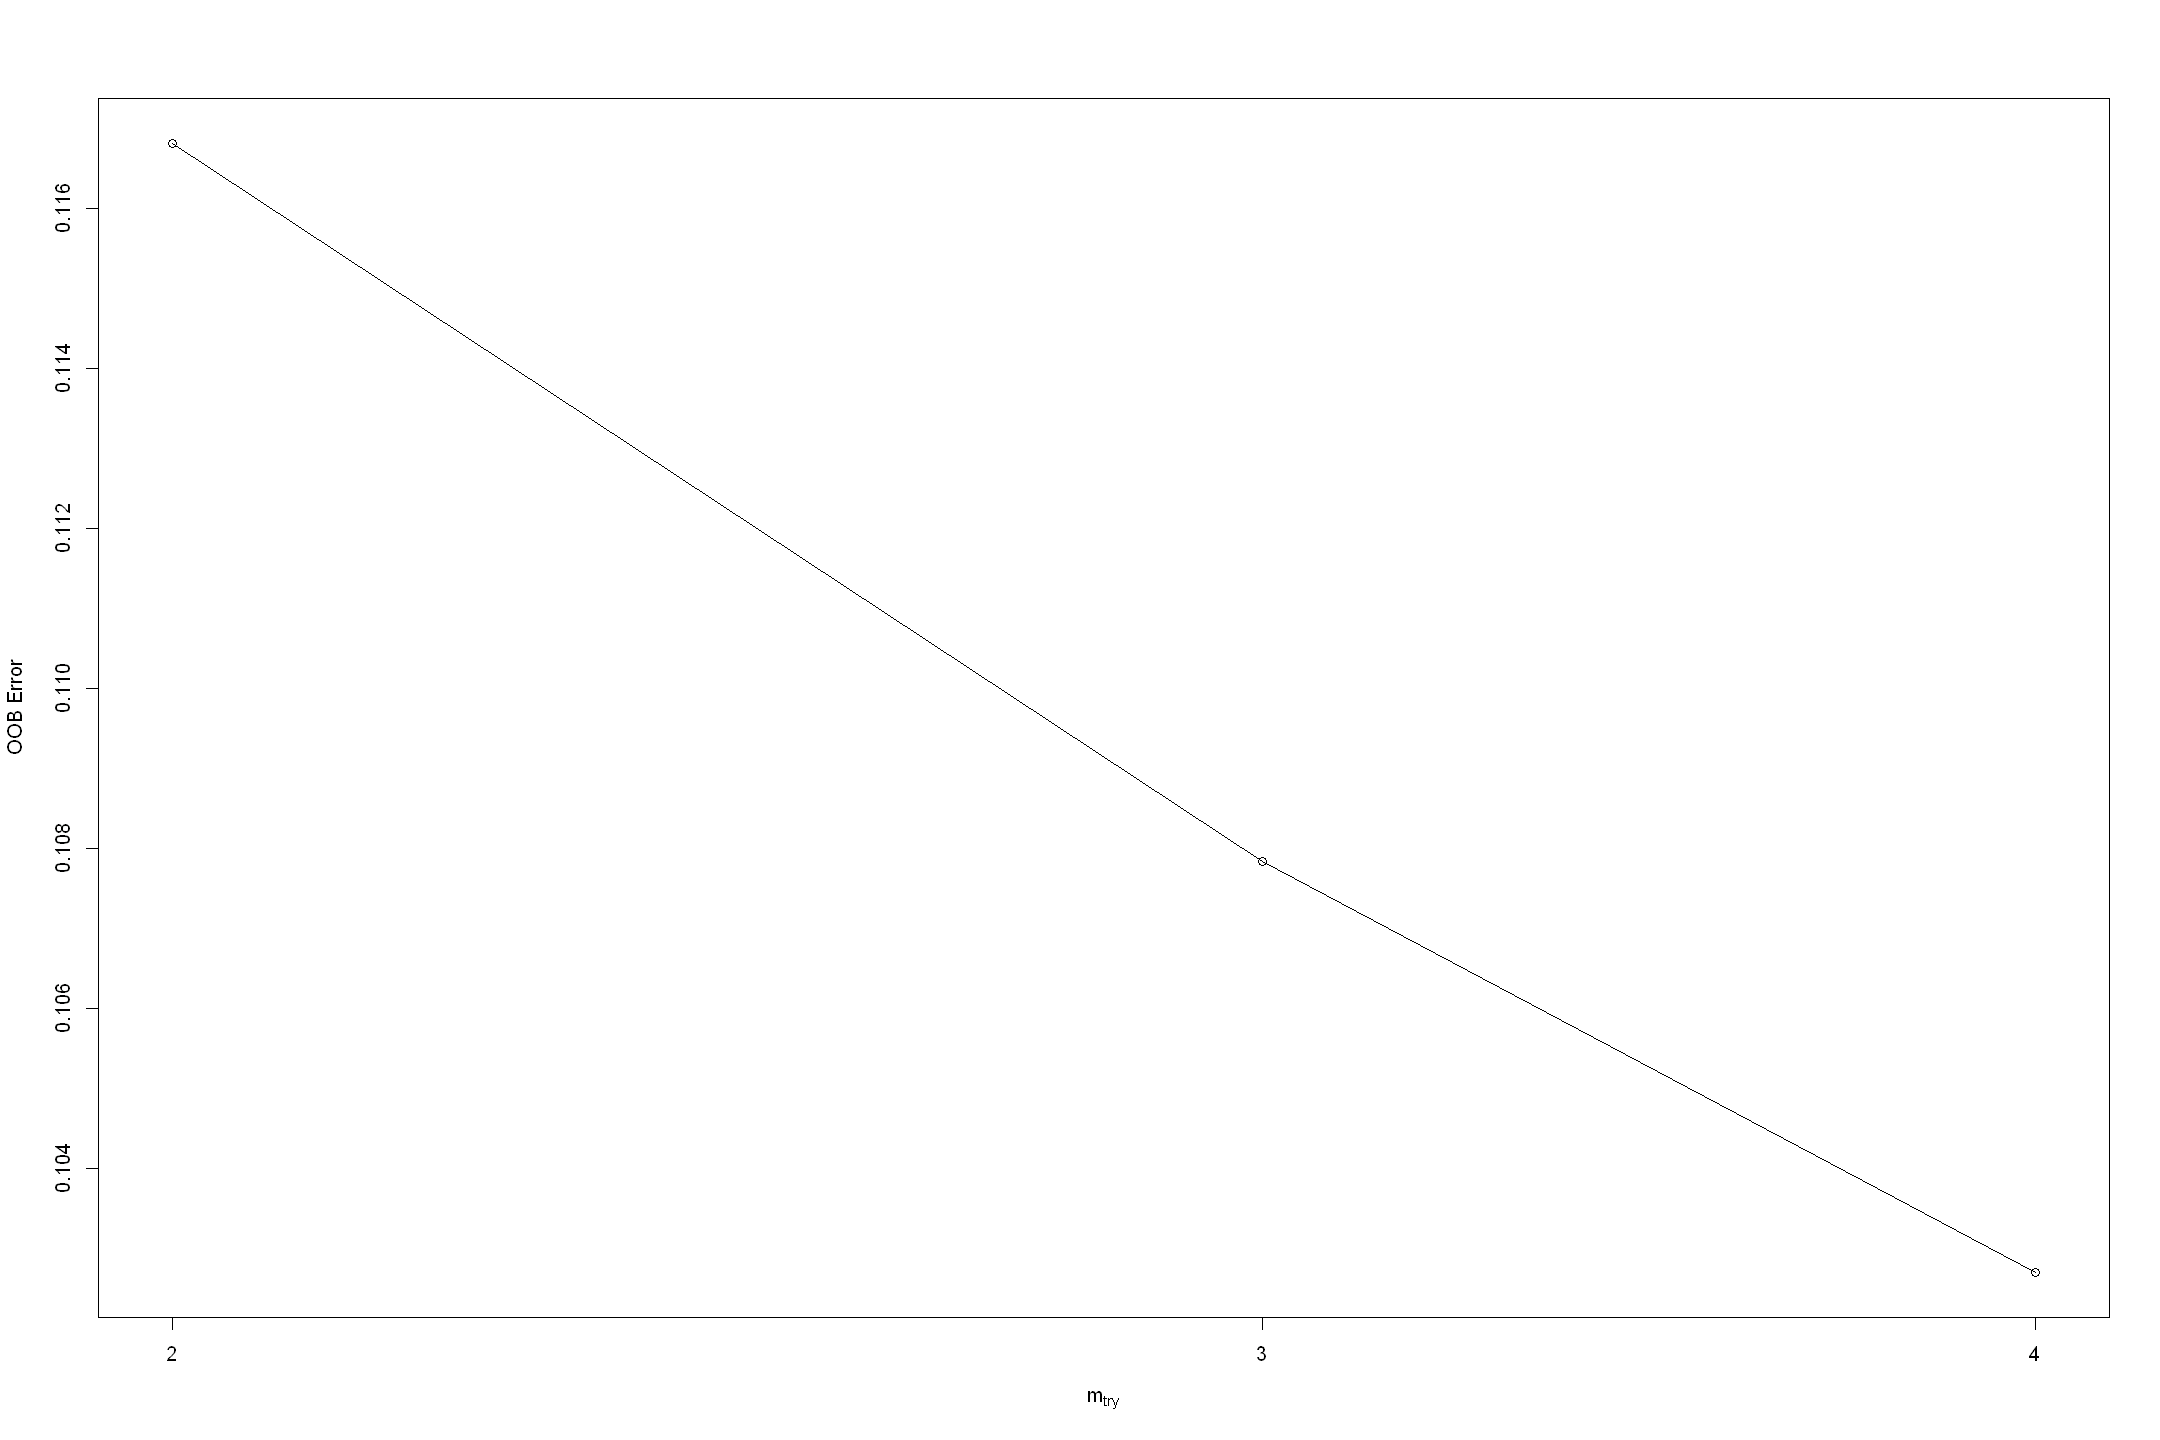

In [25]:
set.seed(24)

# Optimisation du mtry avec tuneRF
best_mtry <- tuneRF(x = gym_train[ , -which(names(gym_train) == "Experience_Level")],
                    y = gym_train$Experience_Level,
                    stepFactor = 1.5,
                    improve = 0.05,
                    ntreeTry = 100,
                    trace = TRUE,
                    plot = TRUE,
                    doBest = TRUE)

optimal_mtry <- best_mtry$mtry
cat("Optimal mtry value:", optimal_mtry, "\n")

Le paramètre `mtry` a été optimisé automatiquement à l'aide de la fonction `tuneRF()`, qui teste différentes valeurs de `mtry` autour d'une valeur initiale (ici, `√p = 4`), en les multipliant ou divisant par un facteur `stepFactor = 1.5`. L'évaluation de chaque `mtry` est réalisée à l'aide de 100 arbres (`ntreeTry = 100`) afin d'obtenir une estimation rapide mais fiable de l'erreur OOB. 

Le processus de tuning s'arrête dès qu'aucune amélioration significative (au moins `5%`) de l'erreur OOB n’est observée (`improve = 0.05`). L’option `doBest = TRUE` permet enfin de réentraîner automatiquement un modèle avec la meilleure valeur trouvée, ce qui facilite l'intégration du tuning dans le workflow.

Cette procédure a confirmé que `mtry = 4` (valeur théorique par défaut pour la classification avec 14 variables explicatives) offrait les meilleures performances, sans amélioration notable au-delà.


In [26]:
# Prédictions Random Forest optimisé (best_mtry) sur test et train
pred_classes_test_best <- predict(best_mtry, gym_test, type = "class")
pred_probs_test_best <- predict(best_mtry, gym_test, type = "prob")

pred_classes_train_best <- predict(best_mtry, gym_train, type = "class")
pred_probs_train_best <- predict(best_mtry, gym_train, type = "prob")

# Matrices de confusion
conf_matrix_test_best <- confusionMatrix(pred_classes_test_best, gym_test$Experience_Level)
conf_matrix_train_best <- confusionMatrix(pred_classes_train_best, gym_train$Experience_Level)

# Log loss (MultiLogLoss)
actual_matrix_test_best <- model.matrix(~gym_test$Experience_Level-1)
actual_matrix_train_best <- model.matrix(~gym_train$Experience_Level-1)
logloss_test_best <- MultiLogLoss(y_pred = pred_probs_test_best, y_true = actual_matrix_test_best)
logloss_train_best <- MultiLogLoss(y_pred = pred_probs_train_best, y_true = actual_matrix_train_best)

# Affichage des résultats
cat("Test Set Performance (Random Forest optimisé):\n")
cat("- Accuracy:", round(conf_matrix_test_best$overall["Accuracy"], 4), "\n")
cat("- Log loss:", round(logloss_test_best, 4), "(lower is better)\n")
cat("- Confusion Matrix:\n")
print(conf_matrix_test_best$table)
cat("\n")

cat("Training Set Performance (Random Forest optimisé):\n")
cat("- Accuracy:", round(conf_matrix_train_best$overall["Accuracy"], 4), "\n")
cat("- Log loss:", round(logloss_train_best, 4), "(lower is better)\n")
cat("- Confusion Matrix:\n")
print(conf_matrix_train_best$table)

Test Set Performance (Random Forest optimisé):
- Accuracy: 0.8918 
- Log loss: 0.2458 (lower is better)
- Confusion Matrix:
          Reference
Prediction  1  2  3
         1 57  3  0
         2 18 78  0
         3  0  0 38

Training Set Performance (Random Forest optimisé):
- Accuracy: 1 
- Log loss: 0.0653 (lower is better)
- Confusion Matrix:
          Reference
Prediction   1   2   3
         1 301   0   0
         2   0 325   0
         3   0   0 153


In [27]:
install.packages("randomForestSRC")
install.packages("ggRandomForests")

package 'randomForestSRC' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'randomForestSRC'"
Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"problem copying C:\Users\doria\AppData\Local\Programs\R\R-4.4.1\library\00LOCK\randomForestSRC\libs\x64\randomForestSRC.dll to C:\Users\doria\AppData\Local\Programs\R\R-4.4.1\library\randomForestSRC\libs\x64\randomForestSRC.dll: Permission denied"
Warning message:
"restored 'randomForestSRC'"



The downloaded binary packages are in
	C:\Users\doria\AppData\Local\Temp\RtmpC6RRab\downloaded_packages
package 'ggRandomForests' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\doria\AppData\Local\Temp\RtmpC6RRab\downloaded_packages


In [28]:
install.packages("ggRandomForest")

Warning message:
"package 'ggRandomForest' is not available for this version of R

A version of this package for your version of R might be available elsewhere,
see the ideas at
https://cran.r-project.org/doc/manuals/r-patched/R-admin.html#Installing-packages"


Warning message:
"package 'ggRandomForests' was built under R version 4.4.3"
Loading required package: randomForestSRC

Warning message:
"package 'randomForestSRC' was built under R version 4.4.3"

 randomForestSRC 3.3.3 
 
 Type rfsrc.news() to see new features, changes, and bug fixes. 
 



Attaching package: 'randomForestSRC'


The following objects are masked from 'package:e1071':

    impute, tune


The following object is masked from 'package:purrr':

    partial




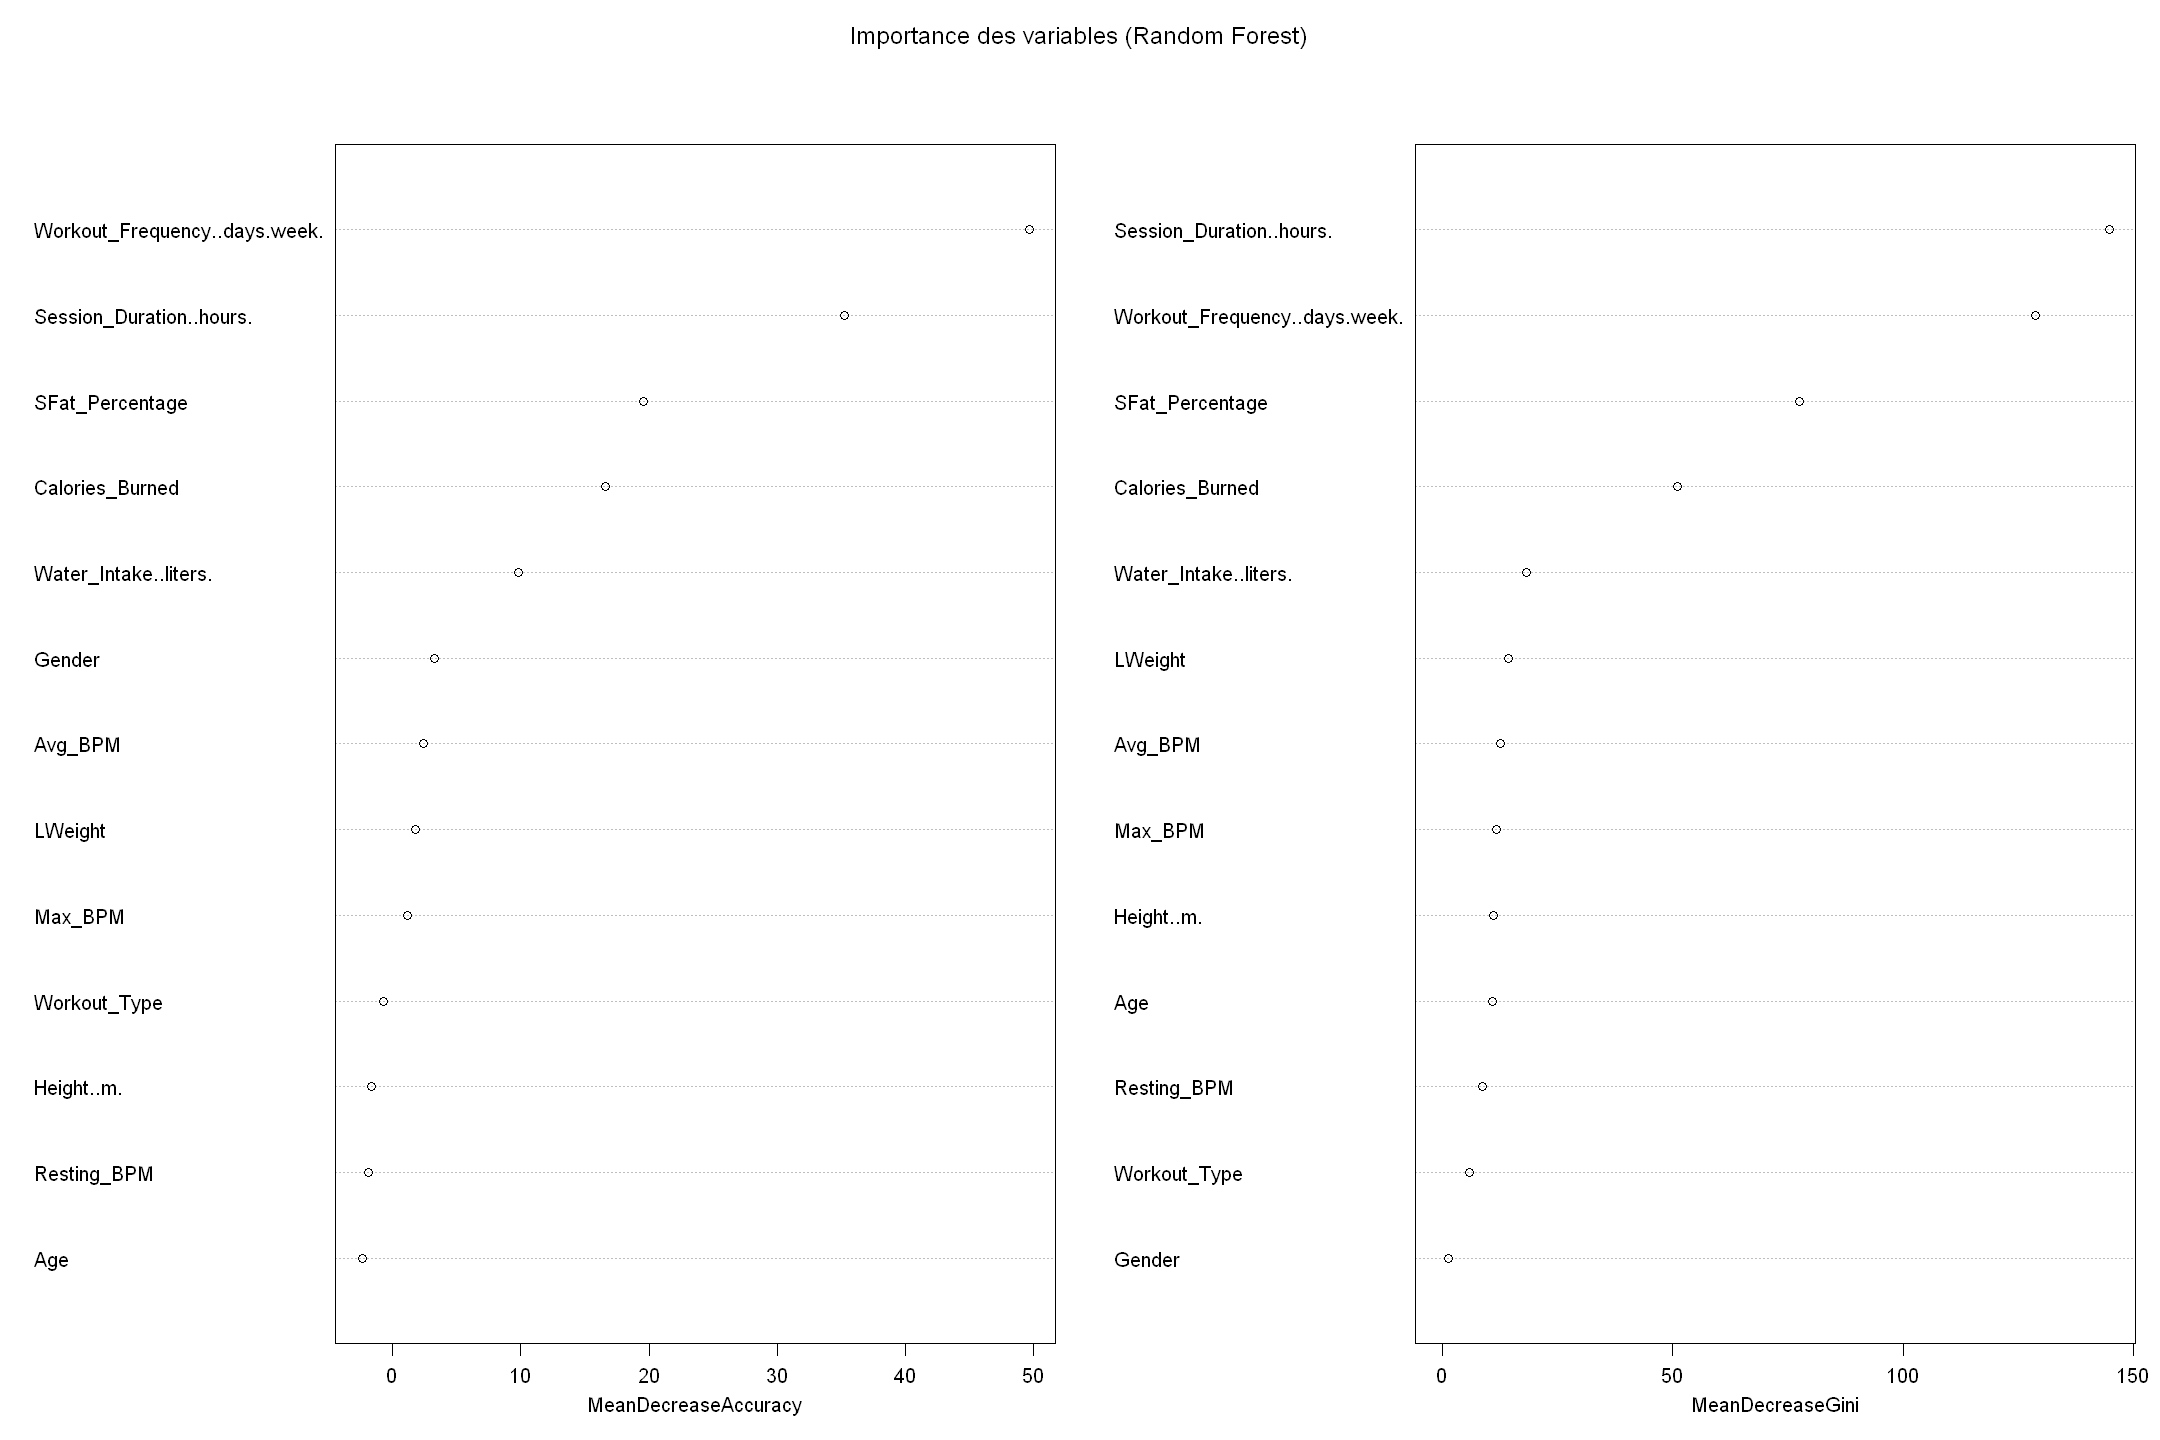

In [29]:
# Importance des variables
library(ggRandomForests)

#Plot importance
varImpPlot(rf_model, main = "Importance des variables (Random Forest)")

L'importance des variables a été évaluée à l’aide des mesures intégrées à l’algorithme Random Forest. Deux métriques complémentaires ont été analysées :

- **Mean Decrease in Accuracy** : elle mesure la perte de précision du modèle lorsque les valeurs d’une variable sont aléatoirement permutées. Cette mesure est considérée comme la plus fiable car elle reflète directement l’impact de la variable sur la performance globale du modèle.
- **Mean Decrease in Gini** : elle correspond à la réduction moyenne de l’impureté des nœuds (indice de Gini) induite par l’utilisation d’une variable pour diviser les données dans les arbres. Bien qu’efficace, cette métrique peut être biaisée en faveur des variables numériques continues.

Le graphique montre que des variables telles que `Session_Duration..hours.`, `Workout_Frequency` ou encore `Fat_Percentage` sont parmi les plus influentes dans la prédiction du niveau d’expérience. Ces résultats sont cohérents avec l’analyse exploratoire, qui avait déjà mis en évidence des corrélations fortes entre ces variables et la variable cible `Experience_Level`.

Cette observation est tout à fait cohérente : les profils les plus expérimentés sont aussi ceux qui cumulent une fréquence d'entraînement élevée, un volume d’exercice important et un taux de masse grasse plus bas, autant d’indicateurs caractéristiques d’une pratique sportive régulière et avancée.

L’analyse de l’importance des variables permet non seulement d’interpréter le modèle, mais aussi d’identifier les facteurs les plus déterminants dans la progression des adhérents d'une salle de sport.


#### Boosting
##### Avec la librairie `xgboost`


#### 1. Entraînement d'un premier modèle baseline

Nous avons d'abord construit un modèle de base en spécifiant les paramètres suivants :
- `objective = "multi:softprob"` : configuration adaptée à une classification multi-classes, permettant d'obtenir les probabilités associées à chaque classe.
- `num_class = 3` : car la variable cible comporte trois niveaux.
- `eval_metric = "mlogloss"` : la fonction de perte choisie est le log loss, adaptée aux probabilités.
- `eta = 0.1` : taux d'apprentissage modéré pour stabiliser l'entraînement.
- `max_depth = 6` : profondeur maximale des arbres.
- `subsample = 0.8` et `colsample_bytree = 0.8` : échantillonnage partiel des données et des variables pour limiter le surapprentissage.

Ce modèle initial a été entraîné avec 300 arbres (`nrounds = 300`).  
Les prédictions ont ensuite été obtenues sous forme de probabilités pour chaque classe.  
La classe prédite correspond à celle ayant la probabilité la plus élevée.

Une évaluation préliminaire par **matrice de confusion** sur le jeu de test a permis d'obtenir une **accuracy de 85.57%**.

---

In [30]:
library(xgboost)
library(caret)

# Créer les matrices d'entraînement
X_train <- model.matrix(Experience_Level ~ . -1, data = gym_train)
y_train <- as.numeric(gym_train$Experience_Level) - 1  # XGBoost demande des labels 0, 1, 2

X_test <- model.matrix(Experience_Level ~ . -1, data = gym_test)
y_test <- as.numeric(gym_test$Experience_Level) - 1

# Transformer en objets DMatrix pour XGBoost
dtrain <- xgb.DMatrix(data = X_train, label = y_train)
dtest <- xgb.DMatrix(data = X_test, label = y_test)


Warning message:
"package 'xgboost' was built under R version 4.4.3"

Attaching package: 'xgboost'


The following object is masked from 'package:plotly':

    slice


The following object is masked from 'package:dplyr':

    slice




In [31]:
# Définir les paramètres
params <- list(
  objective = "multi:softprob",   # pour multi-classes avec probabilités
  num_class = 3,                  # 3 classes ici
  eval_metric = "mlogloss"         # log loss pour la stabilité
)

# Entraîner
set.seed(24)
xgb_model <- xgb.train(
  params = params,
  data = dtrain,
  nrounds = 300,          # 300 arbres
  eta = 0.1,              # learning rate correct
  max_depth = 6,          # arbres raisonnablement profonds
  subsample = 0.8,        # sous-échantillonnage pour éviter overfitting
  colsample_bytree = 0.8, # sous-échantillonnage des colonnes
  verbose = 0
)


In [32]:
# Prédictions : probabilités
pred_probs <- predict(xgb_model, newdata = dtest)

# Reformater en matrice : chaque ligne correspond à un individu
pred_matrix <- matrix(pred_probs, ncol = 3, byrow = TRUE)

# Prendre la classe la plus probable
pred_classes <- max.col(pred_matrix) - 1  # car max.col commence à 1

# Comparer aux vraies classes
confusionMatrix(as.factor(pred_classes), as.factor(y_test))

Confusion Matrix and Statistics

          Reference
Prediction  0  1  2
         0 57 14  0
         1 18 67  0
         2  0  0 38

Overall Statistics
                                          
               Accuracy : 0.8351          
                 95% CI : (0.7752, 0.8844)
    No Information Rate : 0.4175          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.7411          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 0 Class: 1 Class: 2
Sensitivity            0.7600   0.8272   1.0000
Specificity            0.8824   0.8407   1.0000
Pos Pred Value         0.8028   0.7882   1.0000
Neg Pred Value         0.8537   0.8716   1.0000
Prevalence             0.3866   0.4175   0.1959
Detection Rate         0.2938   0.3454   0.1959
Detection Prevalence   0.3660   0.4381   0.1959
Balanced Accuracy      0.8212   0.8339   1.0000

#### 2. Optimisation des hyperparamètres par validation croisée

Afin d'améliorer ce modèle, nous avons mis en place une **recherche sur grille (grid search)** couplée à une **validation croisée 5 folds**.  
La grille explorait les paramètres suivants :
- `nrounds` : 300 et 500
- `max_depth` : 4, 6, 8
- `eta` : 0.05 et 0.1
- `gamma` : 0 et 1
- `colsample_bytree` : 0.7 et 1
- `min_child_weight` : 1 et 5
- `subsample` : 0.7 et 1

Le critère d'optimisation était la **précision (`Accuracy`)** sur les données de validation.

Cette recherche a permis d'identifier la meilleure combinaison d'hyperparamètres.

---

In [33]:
# Grille d'hyperparamètres à explorer
grid <- expand.grid(
  nrounds = c(300, 500),
  max_depth = c(4, 6, 8),
  eta = c(0.05, 0.1),
  gamma = c(0, 1),
  colsample_bytree = c(0.7, 1),
  min_child_weight = c(1, 5),
  subsample = c(0.7, 1)
)

# 5-fold CV
ctrl <- trainControl(
  method = "cv",
  number = 5,
  verboseIter = TRUE,
  allowParallel = TRUE
)

set.seed(24)
xgb_tuned_full <- train(
  Experience_Level ~ .,
  data = gym_train, # Utiliser gym_train au lieu de train_data
  method = "xgbTree",
  trControl = ctrl,
  tuneGrid = grid,
  metric = "Accuracy",
  verbose = 0 # Mettre à 1 ou TRUE pour voir la progression si désiré
)

+ Fold1: eta=0.05, max_depth=4, gamma=0, colsample_bytree=0.7, min_child_weight=1, subsample=0.7, nrounds=500 
[18:04:52] WARNING: src/c_api/c_api.cc:935: `ntree_limit` is deprecated, use `iteration_range` instead.
- Fold1: eta=0.05, max_depth=4, gamma=0, colsample_bytree=0.7, min_child_weight=1, subsample=0.7, nrounds=500 
+ Fold1: eta=0.05, max_depth=4, gamma=0, colsample_bytree=0.7, min_child_weight=1, subsample=1.0, nrounds=500 
[18:04:56] WARNING: src/c_api/c_api.cc:935: `ntree_limit` is deprecated, use `iteration_range` instead.
- Fold1: eta=0.05, max_depth=4, gamma=0, colsample_bytree=0.7, min_child_weight=1, subsample=1.0, nrounds=500 
+ Fold1: eta=0.05, max_depth=4, gamma=0, colsample_bytree=0.7, min_child_weight=5, subsample=0.7, nrounds=500 
[18:05:00] WARNING: src/c_api/c_api.cc:935: `ntree_limit` is deprecated, use `iteration_range` instead.
- Fold1: eta=0.05, max_depth=4, gamma=0, colsample_bytree=0.7, min_child_weight=5, subsample=0.7, nrounds=500 
+ Fold1: eta=0.05, max


#### 3. Entraînement du modèle final

Un modèle final a ensuite été réentraîné sur l'intégralité du jeu `gym_train` en utilisant les hyperparamètres optimaux trouvés.  
Ce modèle utilise :
- Le meilleur `nrounds`
- Le meilleur `max_depth`
- Le meilleur `eta`, `gamma`, `subsample`, `colsample_bytree`, `min_child_weight`

---

In [34]:
# Extraire les meilleurs paramètres trouvés
best_params <- xgb_tuned_full$bestTune

# Créer une matrice DMatrix pour tout gym_train
dtrain <- xgb.DMatrix(data = X_train, label = y_train)

# Réentraîner avec les meilleurs hyperparamètres
set.seed(24)
xgb_final_model <- xgboost(
  data = dtrain,
  objective = "multi:softprob",
  num_class = 3,
  eval_metric = "mlogloss",
  nrounds = best_params$nrounds,
  max_depth = best_params$max_depth,
  eta = best_params$eta,
  gamma = best_params$gamma,
  colsample_bytree = best_params$colsample_bytree,
  min_child_weight = best_params$min_child_weight,
  subsample = best_params$subsample,
  verbose = 0
)

#### 4. Évaluation finale

Les prédictions finales sur le jeu de test `gym_test` ont été réalisées en prenant la classe associée à la probabilité la plus élevée.

L'évaluation par **matrice de confusion** a permis d'obtenir une **accuracy finale** (précision) correspondant à la performance maximale atteinte par le modèle optimisé.

---

In [35]:
# Prédictions finales XGBoost sur le jeu de test (probabilités)
pred_probs_final <- predict(xgb_final_model, newdata = dtest)
pred_matrix_final <- matrix(pred_probs_final, ncol = 3, byrow = TRUE)

# Classe prédite = colonne avec la probabilité max (commence à 1)
pred_classes_final <- max.col(pred_matrix_final)
# Adapter les niveaux pour correspondre à gym_test$Experience_Level
pred_classes_final_factor <- factor(pred_classes_final, levels = 1:3, labels = levels(gym_test$Experience_Level))

# Calcul MultiLogLoss pour le test
actual_matrix_test_xgb <- model.matrix(~gym_test$Experience_Level-1)
logloss_test_xgb <- MultiLogLoss(y_pred = pred_matrix_final, y_true = actual_matrix_test_xgb)

# Accuracy et matrice de confusion (test)
conf_matrix_test_xgb <- confusionMatrix(pred_classes_final_factor, gym_test$Experience_Level)
accuracy_test_xgb <- conf_matrix_test_xgb$overall["Accuracy"]

# Prédictions sur le jeu d'entraînement (probabilités)
pred_probs_train_final <- predict(xgb_final_model, newdata = dtrain)
pred_matrix_train_final <- matrix(pred_probs_train_final, ncol = 3, byrow = TRUE)
pred_classes_train_final <- max.col(pred_matrix_train_final)
pred_classes_train_final_factor <- factor(pred_classes_train_final, levels = 1:3, labels = levels(gym_train$Experience_Level))

actual_matrix_train_xgb <- model.matrix(~gym_train$Experience_Level-1)
logloss_train_xgb <- MultiLogLoss(y_pred = pred_matrix_train_final, y_true = actual_matrix_train_xgb)

# Accuracy et matrice de confusion (train)
conf_matrix_train_xgb <- confusionMatrix(pred_classes_train_final_factor, gym_train$Experience_Level)
accuracy_train_xgb <- conf_matrix_train_xgb$overall["Accuracy"]

# Affichage des résultats
cat("MultiLogLoss XGBoost (test):", round(logloss_test_xgb, 4), "\n")
cat("Accuracy XGBoost (test):", round(accuracy_test_xgb, 4), "\n")
cat("Matrice de confusion (test):\n")
print(conf_matrix_test_xgb$table)
cat("\n")

cat("MultiLogLoss XGBoost (train):", round(logloss_train_xgb, 4), "\n")
cat("Accuracy XGBoost (train):", round(accuracy_train_xgb, 4), "\n")
cat("Matrice de confusion (train):\n")
print(conf_matrix_train_xgb$table)

MultiLogLoss XGBoost (test): 0.2236 
Accuracy XGBoost (test): 0.8814 
Matrice de confusion (test):
          Reference
Prediction  1  2  3
         1 56  4  0
         2 19 77  0
         3  0  0 38

MultiLogLoss XGBoost (train): 0.1417 
Accuracy XGBoost (train): 0.9461 
Matrice de confusion (train):
          Reference
Prediction   1   2   3
         1 259   0   0
         2  42 325   0
         3   0   0 153


### Comparaison des modèles Lise

#### Tableau recapitulatif 

In [36]:
print(results)

                  Methode Accuracy   LogLoss     Temps
Accuracy            Logit   0.8608 0.2558057  3.738958
Accuracy1             LDA   0.8557 0.2298512  2.246977
Accuracy2             KNN   0.7784 0.4992530  2.820027
Accuracy3     SVM radiale   0.8505 0.2774857 30.340128
Accuracy4 SVM polynomiale   0.8557 0.2544166 13.126528


Voici une synthèse combinée des performances des différents modèles testés pour prédire le niveau d'expérience (Experience_Level) :

| Modèle            | Accuracy | Log Loss | Temps (s) |
| :---------------- | :------- | :------- | :-------- |
| **CART**          | **0.902**| **0.198**| N/A       |
| Random Forest     | 0.892    | 0.246    | N/A       |
| XGBoost           | 0.881    | 0.224    | N/A       |
| Logit             | 0.8608   | 0.2558   | 3.74      |
| LDA               | 0.8557   | 0.2299   | **2.25**  |
| SVM polynomiale   | 0.8557   | 0.2544   | 13.13     |
| SVM radiale       | 0.8505   | 0.2775   | 30.34     |
| KNN               | 0.7784   | 0.4993   | 2.82      |

*(N/A : Temps non fourni pour CART, Random Forest et XGBoost dans le tableau initial, mais généralement plus coûteux que LDA/Logit pour RF et XGBoost, et rapide pour CART).*

### Synthèse finale : Comparaison des modèles

Plusieurs modèles d'apprentissage supervisé ont été évalués :

1.  **CART (Classification and Regression Trees)** : Affiche la meilleure performance globale avec l'**accuracy la plus élevée (90.2%)** et la **log loss la plus faible (0.198)**. Cela indique une excellente capacité de classification et des probabilités de prédiction bien calibrées. Son interprétabilité est également un atout.

2.  **Random Forest** : Obtient une très bonne accuracy (89.2%) et une log loss de 0.246. Le modèle est robuste et performant, mais ses probabilités sont un peu moins précises que celles du CART.

3.  **XGBoost** : Atteint une accuracy de 88.1% et une log loss de 0.224. Malgré un tuning approfondi, il reste légèrement en retrait en termes d'accuracy sur ce jeu de données, mais ses probabilités sont mieux calibrées que celles du Random Forest et proches de celles de LDA.

4.  **LDA (Analyse Discriminante Linéaire)** : Ressort comme un modèle très performant, en particulier si l'on considère le compromis performance/rapidité. Il combine une bonne accuracy (85.57%), une excellente log loss (0.230, la deuxième meilleure) et le **temps de calcul le plus court (2.25s)**. Il offre une bonne capacité de discrimination et des probabilités bien calibrées.

5.  **Régression Logistique (Logit)** : Obtient des résultats très proches de ceux de LDA en termes d'accuracy (86.08%) et une log loss de 0.256. Elle reste une alternative robuste, explicable, fiable et rapide (3.74s).

6.  **SVM (Machines à Vecteurs de Support)** :
    *   Le **SVM avec noyau polynomial** (Accuracy: 85.57%, Log Loss: 0.254) donne de bons résultats, comparables à LDA et Logit, mais il est nettement plus lent (13.13s).
    *   Le **SVM avec noyau radial** (Accuracy: 85.05%, Log Loss: 0.277) est encore plus lent (30.34s) sans offrir d'avantage significatif en performance.

7.  **KNN (K Plus Proches Voisins)** : Est clairement le modèle le moins performant ici, avec l'accuracy la plus faible (77.84%) et la log loss la plus élevée (0.499), indiquant qu'il distingue mal les classes.

**Conclusion :**

Pour ce jeu de données, le modèle **CART** se révèle le plus performant en termes de précision pure et de qualité des probabilités.

Cependant, si la rapidité d'exécution est un critère primordial tout en maintenant une excellente qualité de prédiction probabiliste, **LDA** et la **Régression Logistique** sont d'excellents choix, offrant un très bon compromis entre précision, qualité des probabilités et vitesse.

Bien que Random Forest et XGBoost soient réputés pour leur puissance, ils n'ont pas surpassé le modèle CART plus simple sur cet ensemble de données spécifique. Le choix final du modèle dépendra du compromis souhaité entre performance pure, interprétabilité, qualité des probabilités et contraintes de temps de calcul.

### courbes roc

Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases

Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases

Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases

Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases

Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases

Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases

Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases

Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases

Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases

Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases

Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases

Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases

Sett

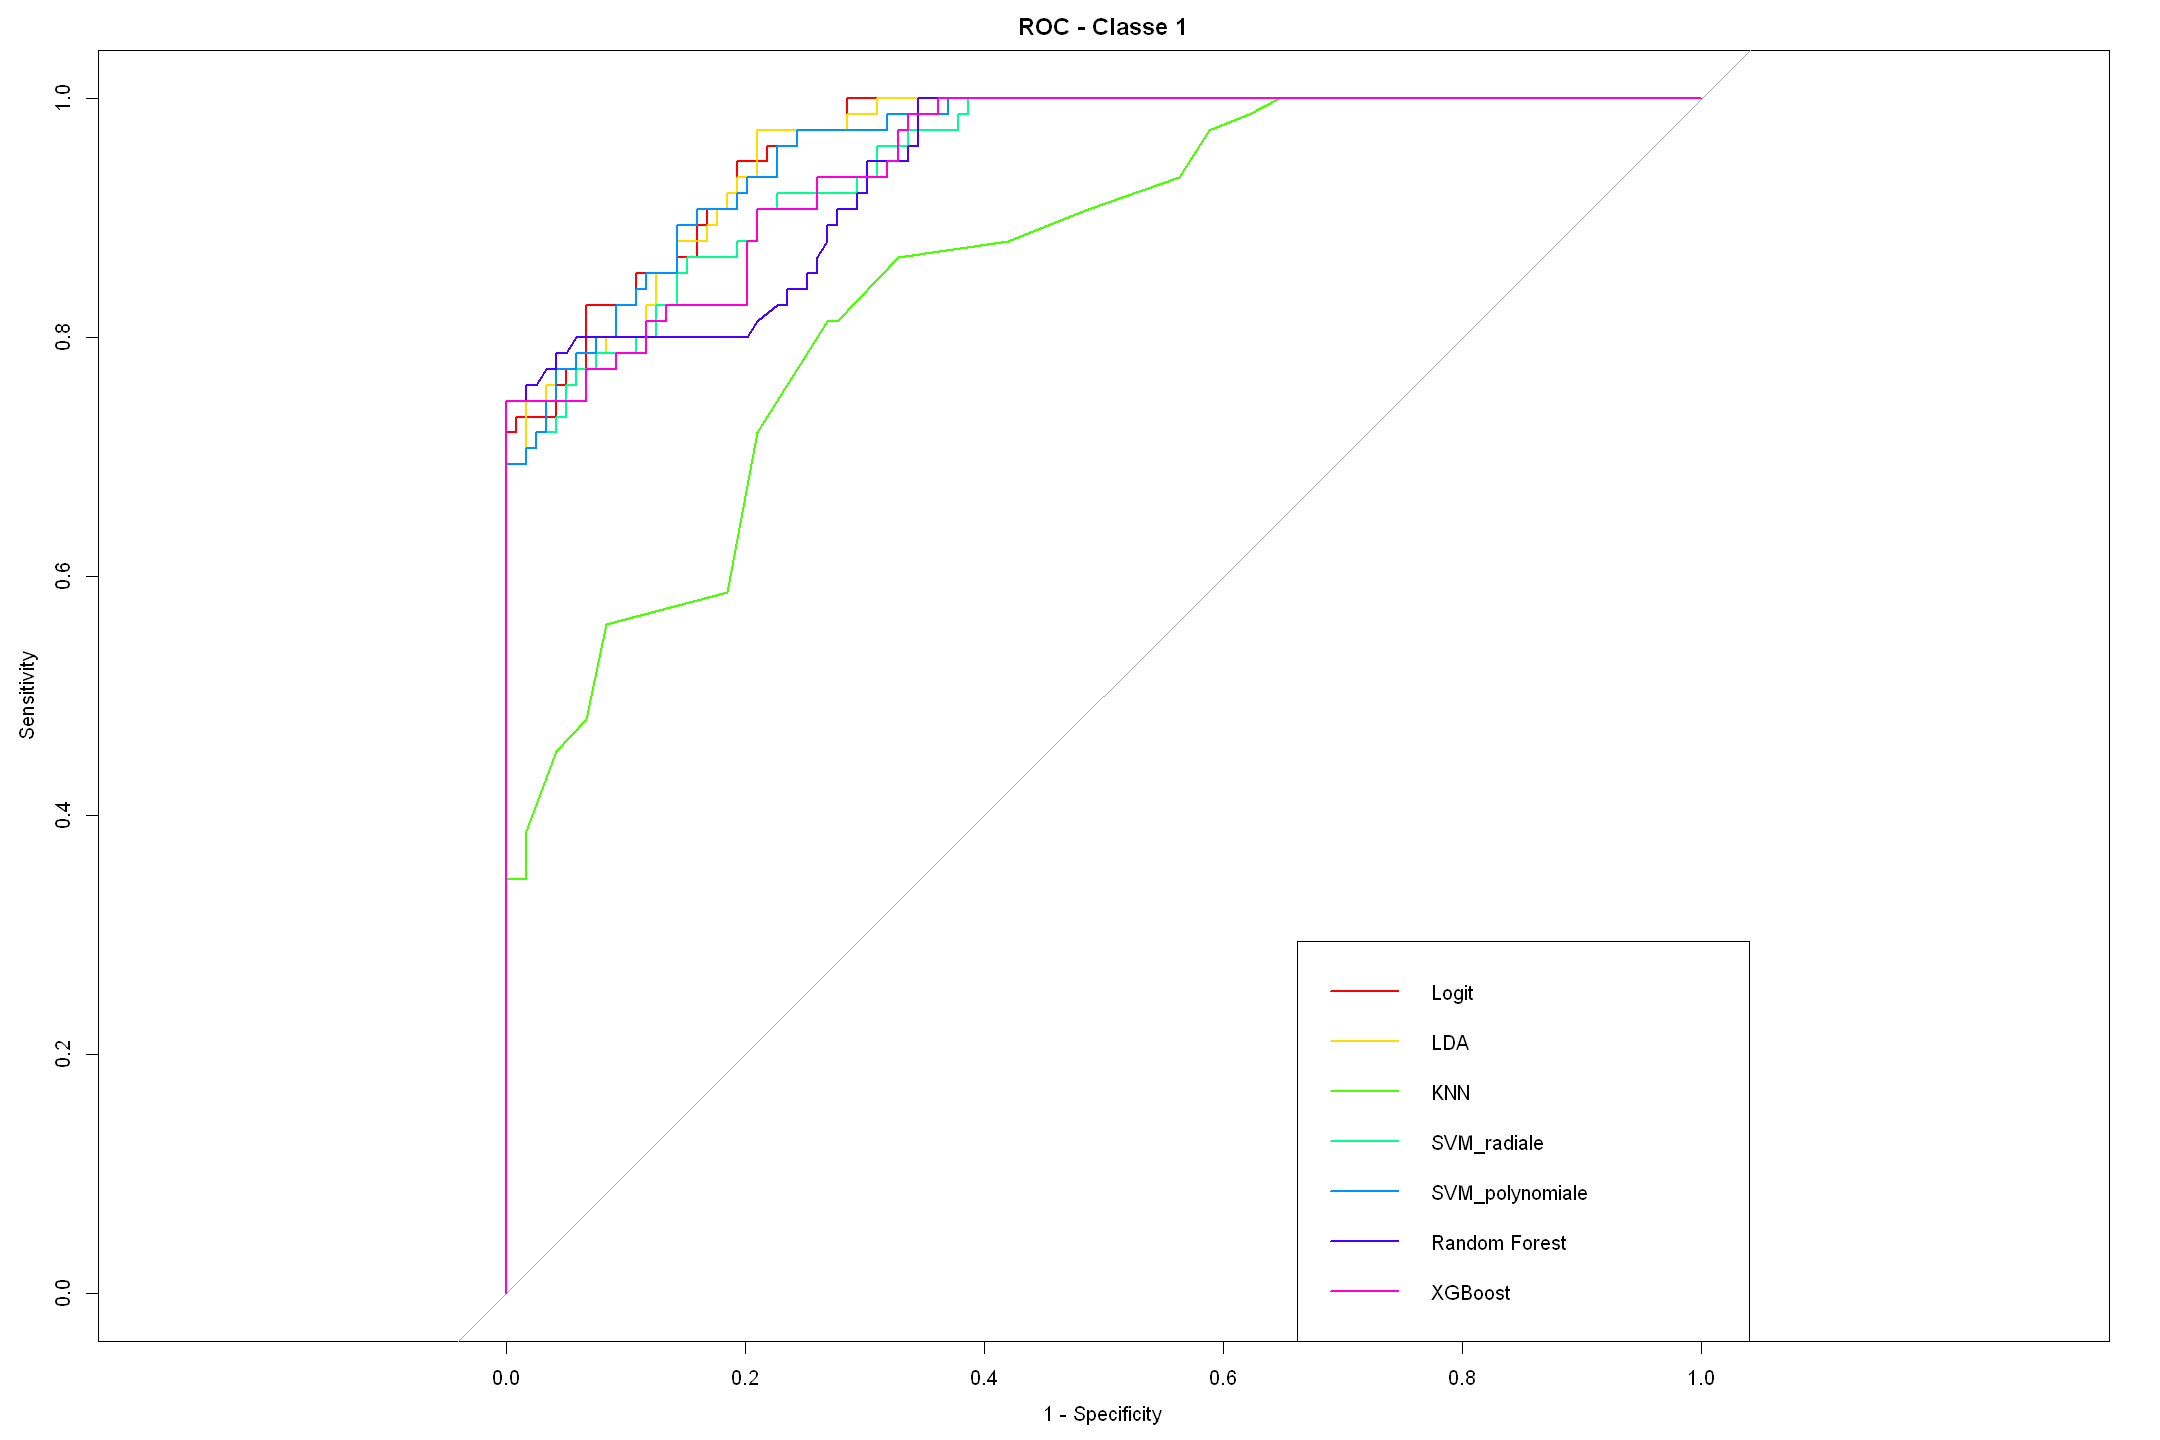

Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases

Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases

Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases

Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases

Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases

Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases

Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases



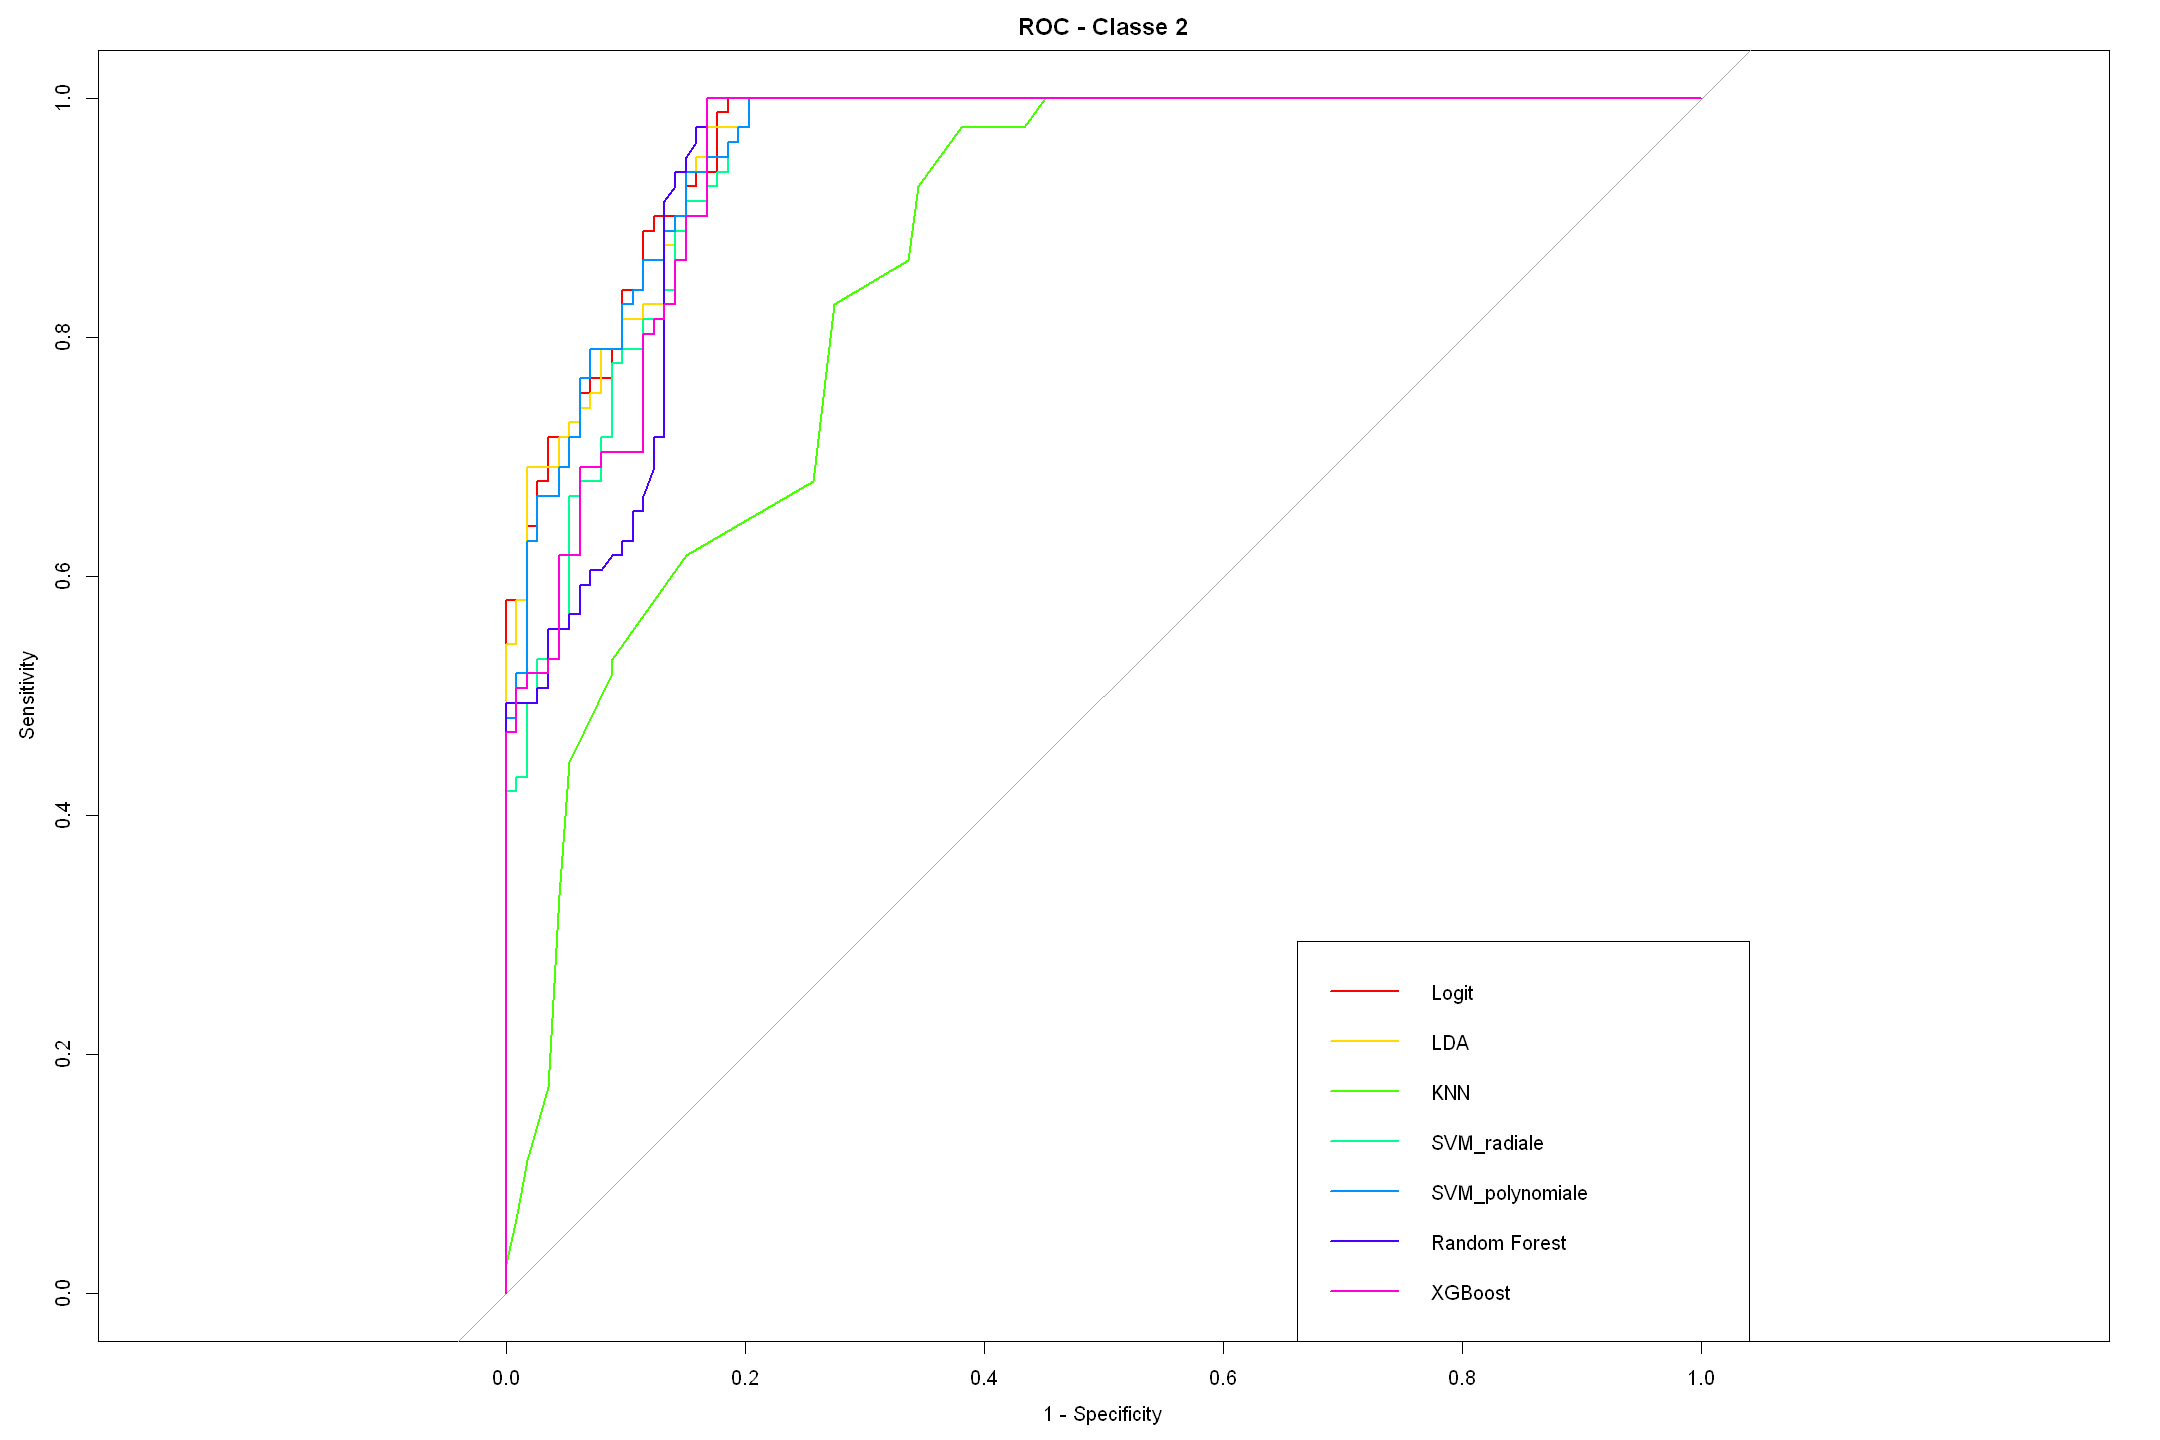

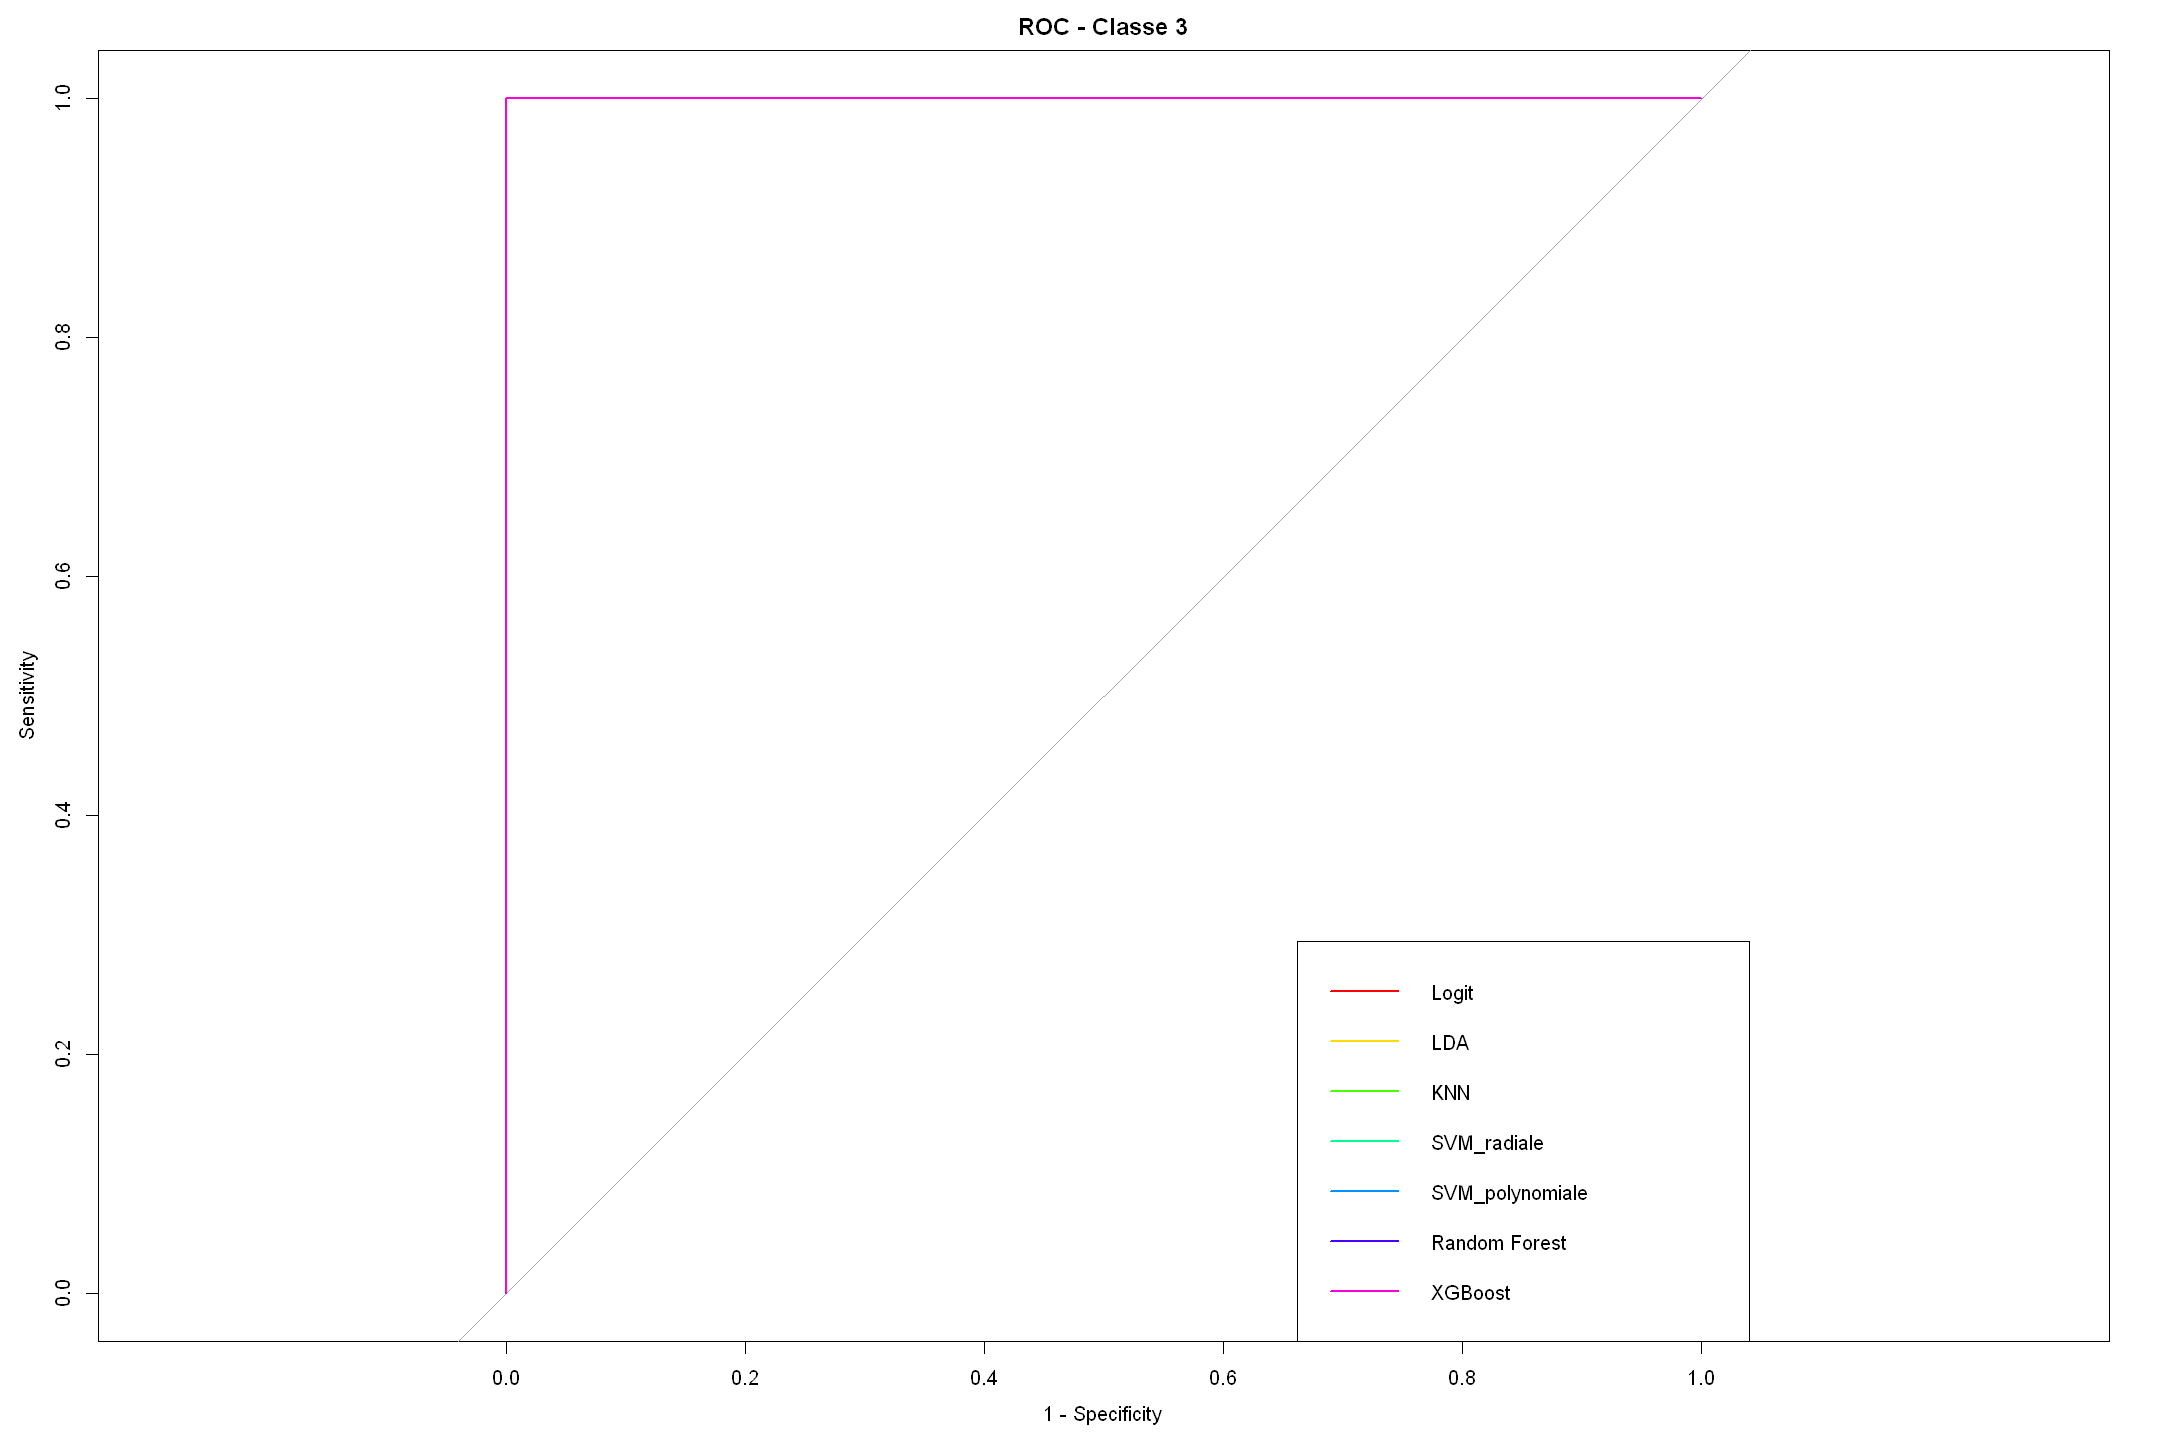

In [39]:
library(pROC)
all_probs <- list(
  "Logit" = probabilities_logit,
  "LDA" = probabilities_lda,
  "KNN" = probabilities_knn,
  "SVM_radiale" = probabilities_svm.rad,
  "SVM_polynomiale" = probabilities_svm.pol,
  "Random Forest" = pred_probs_test_rf,
  "XGBoost" = pred_matrix_final
)

for (cl in 1:3) {
  # Paramètres
  #cl <- "2"  # classe d’intérêt
  models <- names(all_probs)  # les deux modèles à comparer
  # Génération automatique d'autant de couleurs qu'il y a de modèles
  colors <- rainbow(length(models))
  names(colors) <- models


  # Sécuriser les étiquettes
  true_class_test <- as.character(true_class_test)
  response_test <- true_class_test == cl

  # Préparer la liste pour stocker les objets ROC
  roc_list <- list()

  # Boucle sur les deux modèles
  for (model in models) {
    predictor_test <- all_probs[[model]][, cl]
    roc_obj <- roc(response = response_test, predictor = predictor_test)
    roc_list[[model]] <- roc_obj
  }

  # Tracer la première courbe pour initialiser le plot
  plot(roc_list[[models[1]]],
      col = colors[models[1]],
      lwd = 2,
      legacy.axes = TRUE,
      main = paste("ROC - Classe", cl),
      print.auc = FALSE)

  for (i in 2:length(models)) {
    # Ajouter les courbes ROC pour chaque modèle
    lines(roc_list[[models[i]]], col = colors[models[i]], lwd = 2)
  }

  legend("bottomright", legend = names(all_probs), col = colors, lwd = 2)
}

 

On constate ainsément que pour les niveaux d'expérience 1 et 2, le modèle KNN est le moins performant (courbe verte). Les 4 autres modèles ont des performances assez proches, mais la courbe associée à la regression logit étant souvent legerment au dessus des autres, c'est ce modèle le plus performant. 

## Analyse des courbes ROC pour les classes 1, 2 et 3

### Classe 1
- **AUC (CART = 0.954, Random Forest = 0.941, XGBoost = 0.946)** :
  - Le modèle **CART** est légèrement supérieur à **XGBoost** et **Random Forest** pour la classe `1`.
  - Les trois modèles montrent une bonne capacité de discrimination pour cette classe, avec des AUC proches de 1.
- **Conclusion** : CART est le modèle le plus performant pour la classe `1`, suivi de près par XGBoost.

---

### Classe 2
- **AUC (CART = 0.955, Random Forest = 0.943, XGBoost = 0.948)** :
  - CART reste légèrement meilleur que XGBoost et Random Forest pour la classe `2`.
  - Les performances des trois modèles sont similaires, avec des AUC très proches.
- **Conclusion** : CART est encore une fois le modèle le plus performant, mais XGBoost est presque équivalent.

---

### Classe 3
- **AUC (CART = 1, Random Forest = 1, XGBoost = 1)** :
  - Tous les modèles atteignent une AUC parfaite de `1` pour la classe `3`.
  - Cela signifie que les trois modèles discriminent parfaitement la classe `3` des autres classes.
- **Conclusion** : Les trois modèles sont équivalents pour la classe `3`.

---

### Synthèse globale
1. **Classe 1 et Classe 2** :
   - CART est légèrement meilleur que XGBoost et Random Forest pour ces classes, mais les différences sont minimes.
   - Les trois modèles montrent une excellente capacité de discrimination avec des AUC supérieures à `0.94`.

2. **Classe 3** :
   - Tous les modèles atteignent une performance parfaite (AUC = 1), ce qui indique que cette classe est très bien séparée des autres.

3. **Recommandation** :
   - CART est globalement le modèle le plus performant pour ce problème, avec des AUC légèrement supérieures pour les classes `1` et `2`.
   - XGBoost est une alternative compétitive, particulièrement pour des problèmes où une optimisation fine est nécessaire.
   - Random Forest reste robuste et performant, mais légèrement en retrait par rapport aux deux autres modèles.

In [ ]:
# Installer si nécessaire : install.packages("beepr")
install.packages("beepr")
library(beepr)
beep()  # Joue un son à la fin